### Téléchargement des bibliothèques et des données ###

In [16]:
# Téléchargement des bibliothèques
import pandas as pd # type: ignore
import numpy as np # type: ignore
import datetime as dt # type: ignore
from datetime import timedelta # type: ignore
from dateutil.relativedelta import relativedelta # type: ignore
import matplotlib.pyplot as plt
import seaborn as sns
# from pandasgui import show
# import plotly.express as px

In [17]:
# max rows 500
pd.set_option('display.max_rows', 500)
# max columns 500
pd.set_option('display.max_columns', 500)

In [18]:
# Charger et concaténer tous les fichiers Parquet
old_df = pd.concat([
    pd.read_parquet('df_2024.parquet'),
    pd.read_parquet('df_2023.parquet'),
    pd.read_parquet('df_2022.parquet')
])

In [19]:
def generate_df_raw():
    """ generate the raw dataframe containing all the dataframes merged:
    df_dat_dep: dataframe containing the dates of departure from year_m_2 to year_next
    df_voy: dataframe containing the trips from table voyp with the attributes related to the trips
    df_dema: dataframe containing the trips from table dtvv with the attributes related to  trips/dat_dema (mgvs and mvoy).
        The table is resampled to have one row per dat_dema between dat_demamin and dat_demamax for each trip, and forward fill for all other columns
    df_resa: dataframe containing the trips from table revd with the attributes related to the trips/dat_resa (resa).
 
    Returns:
    pd.DataFrame: the raw dataframe containing all the dataframes merged
   
    """
    df_dat_dep = pd.concat(
        [
            pd.read_csv(f"df_dat_dep/df_dat_dep_n_m_2.csv"),
            pd.read_csv(f"df_dat_dep/df_dat_dep_n_m_1.csv"),
            pd.read_csv(f"df_dat_dep/df_dat_dep_n.csv"),
            # pd.read_csv(f"df_dat_dep/df_dat_dep_n_p_1.csv"),
        ],
        ignore_index=True,
    )
    # Converting dat_dep to date
    df_dat_dep["dat_dep"] = pd.to_datetime(df_dat_dep["dat_dep"]).dt.date
 
 
    df_voy = pd.concat(
        [
            pd.read_csv(f"df_voy/df_voy_n_m_2.csv"),
            pd.read_csv(f"df_voy/df_voy_n_m_1.csv"),
            pd.read_csv(f"df_voy/df_voy_n.csv"),
            # pd.read_csv(f"df_voy/df_voy_n_p_1.csv"),
        ],
        ignore_index=True,
    )
    # Converting dat_dep to date
    df_voy["dat_dep"] = pd.to_datetime(df_voy["dat_dep"]).dt.date
    # Converting hor_dep to time
    # df_voy["hor_dep"] = pd.to_datetime(df_voy["hor_dep"]).dt.time
 
    df_dema = pd.concat(
        [
            pd.read_csv(f"df_dema/df_dema_n_m_2.csv"),
            pd.read_csv(f"df_dema/df_dema_n_m_1.csv"),
            pd.read_csv(f"df_dema/df_dema_n.csv"),
            # pd.read_csv(f"df_dema/df_dema_n_p_1.csv"),
        ],
        ignore_index=True,
    )
    # Converting dat_dep to date
    df_dema["dat_dep"] = pd.to_datetime(df_dema["dat_dep"]).dt.date
    # Converting dat_dema to date
    df_dema["dat_dema"] = pd.to_datetime(df_dema["dat_dema"]).dt.date
    # Converting hor_dep to time
    # df_dema["hor_dep"] = pd.to_datetime(df_dema["hor_dep"]).dt.time

    # Calculer la colonne 'resa_courte' sur df_dema
    df_dema['resa_courte'] = df_dema.groupby(['dat_dep', 'cod_lign', 'hor_dep'])['dat_dema'].transform(
        lambda x: (x.max() - x.min()).days < 90
    )
 
    df_resa = pd.concat(
        [
            pd.read_csv(f"df_resa/df_resa_n_m_2.csv"),
            pd.read_csv(f"df_resa/df_resa_n_m_1.csv"),
            pd.read_csv(f"df_resa/df_resa_n.csv"),
            # pd.read_csv(f"df_resa/df_resa_n_p_1.csv"),
        ],
        ignore_index=True,
    )
    # Grouping df_resa by dat_dep, cod_lign, hor_dep, dat_dema
    df_resa = (
        df_resa.groupby(["dat_dep", "cod_lign", "hor_dep", "dat_resa"])
        .agg(
            qte_pax=("qte_pax", "sum"),
            qte_veh=("qte_veh", "sum"),
            qte_cab=("qte_cab", "sum"),
            mnt_resa=("mnt_resa", "sum"),
            qte_ml=("qte_ml", "sum"),
            mnt_fret=("mnt_fret", "sum"),
        )
        .reset_index()
    )
    df_resa.rename(columns={"dat_resa": "dat_dema"}, inplace=True)
    # Converting dat_dep to date
    df_resa["dat_dep"] = pd.to_datetime(df_resa["dat_dep"]).dt.date
    # Converting dat_dema to date
    df_resa["dat_dema"] = pd.to_datetime(df_resa["dat_dema"]).dt.date
    # Convert hor_dep from timedelta to str then to time # TODO remove with next generation of df_resa if ok
    # df_resa["hor_dep"] = df_resa["hor_dep"].astype('str').apply(lambda x:x[-8:])
    # df_resa["hor_dep"] = pd.to_datetime(df_resa["hor_dep"]).dt.time
 
    # Merge the three dataframes
    df = df_dat_dep.merge(df_voy, on="dat_dep", how="left")
    df = df.merge(df_dema, on=["dat_dep", "cod_lign", "hor_dep"], how="left")
 
    df = df.merge(
        df_resa,
        on=["dat_dep", "cod_lign", "hor_dep", "dat_dema"],
        how="left",
    )
    return df
 
# df = generate_df_raw()

In [20]:
new_df = generate_df_raw()

In [21]:
# Fonction de préparation des données
def prepare_data(df_voy):
    """
    Préparation du DataFrame : conversion des dates et extraction des informations
    temporelles pour traitements ultérieurs.
    """
    # Assurer que les colonnes nécessaires existent
    required_columns = ['dat_dep', 'dat_dema', 'dat_crea', 'hor_dep', 'qte_veh']
    for col in required_columns:
        if col not in df_voy.columns:
            raise ValueError(f"La colonne '{col}' est manquante dans le DataFrame.")
    
    # Assurer que les colonnes 'dat_dep', 'dat_dema' et 'dat_crea' sont bien au format datetime
    df_voy['dat_dep'] = pd.to_datetime(df_voy['dat_dep'])
    df_voy['dat_dema'] = pd.to_datetime(df_voy['dat_dema'])
    df_voy['dat_crea'] = pd.to_datetime(df_voy['dat_crea'])

    # Conversion de 'hor_dep' en format datetime avec une heure
    df_voy['hor_dep'] = pd.to_datetime(df_voy['hor_dep'], format='%H:%M:%S', errors='coerce')

    # Extraire l'heure sous forme de nombre
    df_voy['heure_dep'] = pd.to_datetime(df_voy['hor_dep'], format='%H:%M:%S').dt.hour

    # Pour la colonne 'dat_dep' (date de départ): 
    # Ajouter une colonne pour le jour de l'année de départ
    df_voy['Num_jour_annee_dep'] = df_voy['dat_dep'].dt.dayofyear
    # Ajouter une colonne pour le jour du mois de départ                                                                                               
    df_voy['Jour_Mois_dep'] = df_voy['dat_dep'].dt.day
    # Ajouter une colonne pour le jour de la semaine de départ
    df_voy['Jour_Semaine_dep'] = df_voy['dat_dep'].dt.dayofweek  # 0 = Lundi, 6 = Dimanche

    # Pour la colonne 'dat_dema' (date de demande): Extraire le jour 
    df_voy['dat_dema_day'] = df_voy['dat_dema'].dt.day

    # Pour la colonne 'dat_crea' (date de création)
    # Extraire le jour, le mois et l'année
    df_voy['dat_crea_day'] = df_voy['dat_crea'].dt.day
    df_voy['dat_crea_month'] = df_voy['dat_crea'].dt.month
    df_voy['dat_crea_year'] = df_voy['dat_crea'].dt.year

    # Trier par 'dat_dep', 'cod_lign', 'hor_dep', 'dat_dema'
    df_voy = df_voy.sort_values(by=['dat_dep', 'cod_lign', 'hor_dep', 'dat_dema']).reset_index(drop=True)

    # # Calcul de la qte_veh cumulée par dat_dep, cod_lign, hor_dep
    # df_voy['qte_veh_cum'] = df_voy.groupby(['dat_dep', 'cod_lign', 'hor_dep'])['qte_veh'].cumsum()
    # # Renommer qte_veh en qte_veh_jour
    # df_voy.rename(columns={'qte_veh':'qte_veh_jour', 'qte_veh_cum':'qte_veh'}, inplace=True)

    # Calculer le nombre de jours entre la date de création et chaque date de réservation
    df_voy['J_av_dema_depuis_crea'] = (df_voy['dat_dema'] - df_voy['dat_crea']).dt.days
    # Calculer le nombre total de jours de disponibilité du voyage
    df_voy['Jours_totaux_dispo'] = (df_voy['dat_dep'] - df_voy['dat_crea']).dt.days
    # Réservations effectuées dans les 30 premiers jours après création
    df_voy['reservation_premiers_30j'] = df_voy['J_av_dema_depuis_crea'].apply(lambda x: 1 if x <= 30 else 0)

    # Appliquer abs() pour toutes les colonnes numériques pertinentes si les valeurs doivent être positives
    numeric_columns = ['nb_month_to_dep', 'nb_week_to_dep', 'nb_day_to_dep', 'J_av_dema_depuis_crea', 'Jours_totaux_dispo']
    df_voy[numeric_columns] = df_voy[numeric_columns].abs()

    return df_voy

In [22]:
# Préparer les données
new_df_prepared = prepare_data(new_df)
old_df_prepared = prepare_data(old_df)

In [23]:
# Trouver les dates maximales dans l'ancien DataFrame
dat_dep_max = old_df_prepared["dat_dep"].max()
dat_dema_max = old_df_prepared["dat_dema"].max()

In [24]:
# Filtrer sur les bornes temporelles
new_df_filtred = new_df_prepared[
    (new_df_prepared["dat_dep"] <= dat_dep_max) & 
    (new_df_prepared["dat_dema"] <= dat_dema_max)
]

In [25]:
# Calcul de la qte_veh cumulée par dat_dep, cod_lign, hor_dep
new_df_filtred.loc[:, 'qte_veh_cum'] = new_df_filtred.groupby(['dat_dep', 'cod_lign', 'hor_dep'])['qte_veh'].cumsum()

# Renommer qte_veh en qte_veh_jour et qte_veh_cum en qte_veh
new_df_filtred.rename(columns={'qte_veh':'qte_veh_jour', 'qte_veh_cum':'qte_veh'}, inplace=True)
# new_df_filtred.loc[:, 'qte_veh_jour'] = new_df_filtred['qte_veh']
# new_df_filtred.loc[:, 'qte_veh'] = new_df_filtred['qte_veh_cum']

# # Supprimer la colonne intermédiaire si nécessaire
# new_df_filtred = new_df_filtred.drop(columns=['qte_veh_cum'])

C:\Users\vp.vincentelli\AppData\Local\Temp\ipykernel_36548\2236642716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_filtred.loc[:, 'qte_veh_cum'] = new_df_filtred.groupby(['dat_dep', 'cod_lign', 'hor_dep'])['qte_veh'].cumsum()
C:\Users\vp.vincentelli\AppData\Local\Temp\ipykernel_36548\2236642716.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_filtred.rename(columns={'qte_veh':'qte_veh_jour', 'qte_veh_cum':'qte_veh'}, inplace=True)


In [26]:
# Faire un left join entre le nouveau DataFrame et l'ancien pour enrichir les données
df_prepared = new_df_filtred.merge(
    old_df_prepared[['dat_dep', 'cod_lign', 'hor_dep', 'dat_dema', 'mvoy', 'mgvs', 'veh_att','oveh']],
    on=['dat_dep', 'cod_lign', 'hor_dep', 'dat_dema'],
    how='left'
)

In [27]:
# # Appliquer le filtre pour exclure les lignes avec nb_day_to_dep < days_to_exclude
# days_to_exclude = 90
# df_prepared = df_prepared[df_prepared['nb_day_to_dep'] >= days_to_exclude]

# # Appliquer un filtre sur les resa_courtes si nécessaire
# df_prepared = df_prepared[df_prepared["resa_courte"] == False]

In [28]:
# Fonction pour calculer l'abs_err' de la VATT 
def calculate_errors(df_voy):
    """
    Fonction pour calculer les erreurs sur chaque voyage.
    """
    # Trier par 'dat_dep', 'cod_lign', 'hor_dep', 'dat_dema'
    df_voy = df_voy.sort_values(by=['dat_dep', 'cod_lign', 'hor_dep', 'dat_dema']).reset_index(drop=True)
    # Calcul de `abs-err` avec la valeur de la dernière ligne de `qte_veh` comme valeur fixe
    valeur_fixe = df_voy['qte_veh'].iloc[-1] #FIXME tu prends la qte_veh de la dernière ligne de df_voy, il faut donc appliquer la fonction par voyage avec un groupby (cf calculate_errors_2)
    df_voy['abs-err'] = abs(valeur_fixe - df_voy['veh_att'])
    return df_voy

In [29]:
# Calculer l'erreur de la VATT
df_with_abs_err = calculate_errors(df_prepared)

count    4.618507e+06
mean     1.031645e+02
std      6.248414e+01
min      0.000000e+00
25%      7.700000e+01
50%      1.070000e+02
75%      1.140000e+02
max      3.586857e+03
Name: abs-err, dtype: float64

In [31]:
df_with_abs_err.query("dat_dep == '2024-07-12' & cod_lign=='TA'").to_clipboard(sep=";", decimal=",", index=False)

In [32]:
def calculate_errors_2(df_voy):
    """
    Fonction pour calculer les erreurs sur chaque voyage.
    """
    # Calcul de `abs-err` avec la valeur de la dernière ligne de `qte_veh` comme valeur fixe
    valeur_fixe = df_voy['qte_veh'].iat[-1] #FIXME tu prends la qte_veh final de la dernière ligne, il faut donc appliqer la fonction par voyage avec un groupby
    df_voy['abs-err'] = abs(valeur_fixe - df_voy['veh_att'])
    return df_voy

df_prepared = df_prepared.sort_values(by=['dat_dep', 'cod_lign', 'hor_dep', 'dat_dema']).reset_index(drop=True) # faire une fois avant la fonction plutôt pour chaque voyage
df_with_abs_err = df_prepared.groupby(["dat_dep", "cod_lign", "hor_dep"]).apply(calculate_errors).reset_index(drop=True)
df_with_abs_err.query("dat_dep == '2024-07-12' & cod_lign=='TA'").to_clipboard(sep=";", decimal=",", index=False)

In [50]:
# Fonction pour ajouter les colonnes de dates cibles pour chaque horizon de prévision et calculer les colonnes qte_veh_m_X, veh_att_m_X, mvoy_m_X, mgvs_m_X
def add_and_calculate_horizons_with_join(
    df_voy, horizons, days_to_exclude=0, filter_resa_courte=False
):
    """
    Ajoute des colonnes de dates cibles pour chaque horizon de prévision et calcule les colonnes qte_veh_m_X, veh_att_m_X, mvoy_m_X,
    mgvs_m_X via une jointure sur les dates cibles, en excluant les lignes selon les conditions données.

    Args:
        df_voy (DataFrame): Le DataFrame d'origine.
        horizons (list): Liste des horizons en mois à calculer.
        days_to_exclude (int): Seuil pour exclure les lignes trop proches du départ.
        filter_resa_courte (bool): Filtrer les voyages à réservation courte (facultatif).

    Returns:
        DataFrame: Le DataFrame avec les colonnes de dates cibles et les colonnes qte_veh_m_X, veh_att_m_X, mvoy_m_X, mgvs_m_X ajoutées.
    """
    # Créer une copie pour éviter de modifier l'original
    df_voy = df_voy.copy()

    # Appliquer le filtre pour exclure les lignes avec nb_day_to_dep < days_to_exclude
    # if days_to_exclude > 0:
    #     df_voy = df_voy[df_voy["nb_day_to_dep"] >= days_to_exclude]

    # filtrer sur les dates de réservations avant le plus petit horizon
    df_voy = df_voy[df_voy["dat_dema"] <= df_voy["dat_dep"] - pd.DateOffset(months=min(horizons))]

    # Si filter_resa_courte est activé, appliquer un filtre supplémentaire si nécessaire
    if filter_resa_courte:
        df_voy = df_voy[df_voy["resa_courte"] == False]

    # Ajouter les colonnes pour chaque horizon
    for horizon in horizons:
        df_voy[f"dat_dema_h_{horizon}"] = df_voy["dat_dema"] - pd.DateOffset(
            months=horizon - min(horizons)
        )

        # Jointure pour trouver les valeurs correspondantes
        df_voy = df_voy.merge(
            df_voy[
                [
                    "dat_dep",
                    "cod_lign",
                    "hor_dep",
                    "dat_dema",
                    "qte_veh",
                    "veh_att",
                    "mvoy",
                    "mgvs",
                ]
            ],
            left_on=["dat_dep", "cod_lign", "hor_dep", f"dat_dema_h_{horizon}"],
            right_on=["dat_dep", "cod_lign", "hor_dep", "dat_dema"],
            how="left",
            suffixes=("", f"_{horizon}"),
        )

        # Renommer les colonnes jointes
        df_voy = df_voy.rename(
            columns={
                f"qte_veh_{horizon}": f"qte_veh_m_{horizon}",
                f"veh_att_{horizon}": f"veh_att_m_{horizon}",
                f"mvoy_{horizon}": f"mvoy_m_{horizon}",
                f"mgvs_{horizon}": f"dat_dema_h_{horizon}",
            }
        )

    # Supprimer les colonnes temporaires de dates cibles
    drop_cols = [f"dat_dema_h_{horizon}" for horizon in horizons]
    df_voy = df_voy.drop(columns=drop_cols)

    # Retransforme la colonne 'hor_dep' en format time
    df_voy["hor_dep"] = df_voy["hor_dep"].dt.time

    return df_voy

In [51]:
# Ajouter les dates cibles pour les horizons et calculer les colonnes d'horizons
horizons = [3, 4, 5, 6, 7, 8]
df_with_target_and_horizons = add_and_calculate_horizons_with_join(df_with_abs_err, horizons, days_to_exclude=90, filter_resa_courte=True)

In [52]:
# Garder uniquement la dernière ligne pour chaque combinaison
def keep_last_row_per_group(df_voy):
    """
    Trie et garde la dernière ligne pour chaque groupe.
    """
    # # Retransforme la colonne 'hor_dep' en format time
    # df_voy['hor_dep'] = df_voy['hor_dep'].dt.time
    return df_voy.groupby(['dat_dep', 'cod_lign', 'hor_dep'], as_index=False).last()

In [53]:
# Garder la dernière ligne par groupe
df_final = keep_last_row_per_group(df_with_target_and_horizons)

In [54]:
# Exporter le DataFrame 
df_final.to_excel("df_final.xlsx", index=False)

In [55]:
# Définir les critères pour le voyage à extraire
voyage_critere = {
    'dat_dep': '2024-07-12',
    'cod_lign': 'TA',
    'hor_dep': '21:00:00'
}

# Filtrer le DataFrame pour extraire uniquement ce voyage
voyage_extrait = df_final.loc[
    (df_final['dat_dep'] == voyage_critere['dat_dep']) &
    (df_final['cod_lign'] == voyage_critere['cod_lign']) &
    (df_final['hor_dep'].astype(str) == voyage_critere['hor_dep'])
]

# Afficher les colonnes principales et les colonnes d'horizons
V = voyage_extrait[['dat_dep', 'cod_lign', 'hor_dep', 'qte_veh', 'qte_veh_m_3', 'qte_veh_m_4', 'qte_veh_m_5', 'qte_veh_m_6', 'qte_veh_m_7', 'qte_veh_m_8', 
                    'veh_att_m_3', 'veh_att_m_4', 'veh_att_m_5', 'veh_att_m_6', 'veh_att_m_7', 'veh_att_m_8']]
V

,dat_dep,cod_lign,hor_dep,qte_veh,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8
14391,2024-07-12,TA,21:00:00,321.0,321.0,279.0,227.0,152.0,77.0,37.0,368.857143,656.428571,567.142857,667.285714,77.0,37.0


In [ ]:
# Copier le DataFrame filtré dans le presse-papiers
voyage_extrait.to_clipboard(index=False, sep='\t')

In [164]:
# Trouver les indices des valeurs problématiques
problematic_mask = df_final[df_final['qte_veh'] <= 0]
problematic_mask

,dat_dep,cod_lign,hor_dep,year_dep,month_dep,year_month_dep,week_dep,matching_date_current_year,eta_ouver,jour_nuit,lil_comp,cod_navi,lil_navi,cod_gvs,sens,dat_crea,datetime_dep,hor_arriv,hor_comm,dat_dema,qte_m3,qte_m4,year_dema,month_dema,week_dema,nb_month_to_dep,nb_week_to_dep,nb_day_to_dep,matching_date_dema_current_year,resa_courte,qte_pax,qte_veh_jour,qte_cab,mnt_resa,qte_ml,mnt_fret,heure_dep,Num_jour_annee_dep,Jour_Mois_dep,Jour_Semaine_dep,dat_dema_day,dat_crea_day,dat_crea_month,dat_crea_year,J_av_dema_depuis_crea,Jours_totaux_dispo,reservation_premiers_30j,qte_veh,mvoy,mgvs,veh_att,oveh,abs-err,dat_dema_3,qte_veh_m_3,veh_att_m_3,mvoy_m_3,mgvs_m_3,dat_dema_4,qte_veh_m_4,veh_att_m_4,mvoy_m_4,mgvs_m_4,dat_dema_5,qte_veh_m_5,veh_att_m_5,mvoy_m_5,mgvs_m_5,dat_dema_6,qte_veh_m_6,veh_att_m_6,mvoy_m_6,mgvs_m_6,dat_dema_7,qte_veh_m_7,veh_att_m_7,mvoy_m_7,mgvs_m_7,dat_dema_8,qte_veh_m_8,veh_att_m_8,mvoy_m_8,mgvs_m_8
23,2022-01-03,AD,07:00:00,2022,1,202201,1,2024-01-01,P,J,Inter-Iles,18,Mega Andrea,ICIS,S,2021-03-18,2022-01-03 07:00:00,None,None,2021-10-05,2.0,0.0,2021.0,10.0,40.0,3.0,13.0,90.0,2024-10-01,False,4.0,0.0,0.0,48.20,0.0,0.0,7,3,3,0,5.0,18,3,2021,201.0,291,0,0.0,0.0,2.0,0.0,0.0,115.0,2021-07-05,NaN,0.0,0.0,1.0,2021-06-05,NaN,0.0,0.0,1.0,2021-05-05,NaN,0.0,0.0,1.0,2021-04-05,NaN,0.0,0.0,2.0,2021-03-05,NaN,0.0,0.0,1.0,NaT,NaN,NaN,NaN,NaN
27,2022-01-03,DA,16:00:00,2022,1,202201,1,2024-01-01,P,J,Inter-Iles,18,Mega Andrea,ICIS,S,2021-03-18,2022-01-03 16:00:00,None,None,2021-10-05,2.0,0.0,2021.0,10.0,40.0,3.0,13.0,90.0,2024-10-01,False,0.0,0.0,0.0,0.00,0.0,0.0,16,3,3,0,5.0,18,3,2021,201.0,291,0,0.0,0.0,2.0,2.0,0.0,113.0,2021-07-05,0.0,2.0,0.0,1.0,2021-06-05,0.0,2.0,0.0,1.0,2021-05-05,0.0,2.0,0.0,1.0,2021-04-05,0.0,4.0,0.0,2.0,2021-03-05,NaN,3.0,0.0,1.0,NaT,NaN,NaN,NaN,NaN
59,2022-01-08,NB,23:30:00,2022,1,202201,1,2024-01-06,P,N,Corse-France,19,Pascal Lota,CTIC,E,2021-03-18,2022-01-08 23:30:00,None,None,2021-10-10,36.0,6.0,2021.0,10.0,40.0,3.0,13.0,90.0,2024-10-06,False,0.0,0.0,0.0,0.00,0.0,0.0,23,8,8,5,10.0,18,3,2021,206.0,296,0,0.0,6.0,36.0,23.0,0.0,92.0,2021-07-10,0.0,23.0,0.0,1.0,2021-06-10,NaN,23.0,0.0,3.0,2021-05-10,NaN,23.0,0.0,1.0,2021-04-10,NaN,23.0,0.0,2.0,2021-03-10,NaN,27.0,0.0,1.0,2021-02-10,NaN,26.0,0.0,1.0
69,2022-01-10,AD,07:00:00,2022,1,202201,2,2024-01-08,P,J,Inter-Iles,12,Mega Express II,ICIS,S,2021-03-18,2022-01-10 07:00:00,None,None,2021-10-12,1.0,0.0,2021.0,10.0,41.0,3.0,13.0,90.0,2024-10-08,False,0.0,0.0,0.0,0.00,0.0,0.0,7,10,10,0,12.0,18,3,2021,208.0,298,0,0.0,0.0,1.0,0.0,0.0,115.0,2021-07-12,NaN,0.0,0.0,1.0,2021-06-12,NaN,0.0,0.0,1.0,2021-05-12,NaN,0.0,0.0,1.0,2021-04-12,NaN,0.0,0.0,1.0,2021-03-12,NaN,0.0,0.0,1.0,NaT,NaN,NaN,NaN,NaN
70,2022-01-10,AT,21:00:00,2022,1,202201,2,2024-01-08,P,N,Corse-France,12,Mega Express II,CTIC,S,2021-03-18,2022-01-10 21:00:00,None,None,2021-10-12,17.0,1.0,2021.0,10.0,41.0,3.0,13.0,90.0,2024-10-08,False,1.0,0.0,0.0,14.48,0.0,0.0,21,10,10,0,12.0,18,3,2021,208.0,298,0,0.0,0.0,17.0,8.0,0.0,107.0,2021-07-12,0.0,8.0,0.0,2.0,2021-06-12,NaN,8.0,0.0,7.0,2021-05-12,NaN,8.0,0.0,1.0,2021-04-12,NaN,8.0,0.0,1.0,2021-03-12,NaN,9.0,0.0,1.0,2021-02-12,NaN,9.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17350,2024-11-26,BL,08:00:00,2024,11,202411,48,2024-11-26,P,J,Corse-Italie,12,Mega Express II,CTIC,S,2024-01-16,2024-11-26 08:00:00,12:30:00,13:00:00,2024-08-28,13.0,0.0,2024.0,8.0,35.0,3.0,13.0,90.0,2024-08-28,False,0.0,0.0,0.0,0.00,0.0,0.0,8,331,26,1,28.0,16,1,2024,225.0,315,0,0.0,0.0,13.0,0.0,32.0,115.0,2024-05-28,0.0,0.0,1.0,7.0,2024-04-28,NaN,0.0,0.0,3.0,2024-03-28,NaN,0.0,0.0,1.0,2024-02-28,NaN,0.0,0.0,2.0,2024-01-28,NaN,0.0,0.0,5.0,NaT,NaN,NaN,NaN,NaN
17352,2024-11-26,LB,13:45:00,20

In [145]:
problematic_mask.to_excel("prob.xlsx", index=False)

### Sélections matrices différentes mailles ###

#### Première maille ####

In [24]:
# Définir les colonnes de regroupement et celles à agréger
colonnes_regroupement = ['Num_jour_annee_dep', 'dat_dep', 'cod_lign', 'jour_nuit']
colonnes_a_agreger_sum = [
    'qte_veh', 'qte_veh_m_3', 'qte_veh_m_4', 'qte_veh_m_5', 
    'qte_veh_m_6', 'qte_veh_m_7', 'qte_veh_m_8',
    'veh_att_m_3', 'veh_att_m_4', 'veh_att_m_5', 
    'veh_att_m_6', 'veh_att_m_7', 'veh_att_m_8',
    'mvoy_m_3', 'mvoy_m_4', 'mvoy_m_5', 'mvoy_m_6', 'mvoy_m_7', 'mvoy_m_8',
    'oveh', 'abs-err'
]
# Colonnes à agréger avec une méthode différente (par exemple, max ou mean)
colonnes_a_agreger_max = [
    'mgvs_m_3', 'mgvs_m_4', 'mgvs_m_5', 'mgvs_m_6', 'mgvs_m_7', 'mgvs_m_8'
]
# Construire le dictionnaire d'agrégation
dict_agg = {}
# Ajouter les colonnes à agréger par "sum"
for col in colonnes_a_agreger_sum:
    dict_agg[col] = pd.NamedAgg(column=col, aggfunc="sum")

# Ajouter les colonnes à agréger par "max"
for col in colonnes_a_agreger_max:
    dict_agg[col] = pd.NamedAgg(column=col, aggfunc="max")

# # Création d'un dictionnaire pour l'agrégation avec le nouveau format pour agg ex: df.agg(x=('A', 'max'), y=('B', 'min'), z=('C', 'mean'))
# dict_agg = {col: pd.NamedAgg(column=f"{col}", aggfunc="sum") for col in colonnes_a_agreger} 

# Ajout de la colonne 'nb_voy' pour compter le nombre de voyages
dict_agg['nb_voy'] = pd.NamedAgg(column=f"dat_dep", aggfunc="count")

# Agrégation des données en utilisant la syntaxe avec colonnes nommées
df_maille_aggregee = df_final.groupby(colonnes_regroupement, as_index=False).agg(**dict_agg)

In [25]:
# Dataframe trié par valeur de 'abs-err' décroissante
df_maille_aggregee = df_maille_aggregee.sort_values(by='abs-err', ascending=False)
df_maille_aggregee

,Num_jour_annee_dep,dat_dep,cod_lign,jour_nuit,qte_veh,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,oveh,abs-err,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy
8634,212,2024-07-30,NI,J,450.0,78.0,29.0,14.0,1.0,0.0,0.0,336.571429,30.000000,14.0,1.0,0.0,0.0,13.0,11.0,0.0,2.0,0.0,0.0,879.0,1004.285714,451.0,335.0,78.0,169.0,NaN,NaN,2
9487,223,2024-08-10,LR,J,606.0,230.0,113.0,34.0,3.0,0.0,0.0,1335.714286,1839.285714,34.0,3.0,0.0,0.0,87.0,153.0,13.0,0.0,0.0,0.0,922.0,890.285714,632.0,807.0,80.0,0.0,NaN,NaN,2
8870,215,2024-08-02,NI,J,531.0,209.0,76.0,28.0,8.0,0.0,0.0,648.571429,76.000000,28.0,8.0,0.0,0.0,57.0,50.0,7.0,0.0,0.0,0.0,780.0,815.285714,1622.0,915.0,249.0,0.0,NaN,NaN,2
8478,210,2024-07-28,NI,J,414.0,113.0,37.0,11.0,0.0,0.0,0.0,529.000000,37.000000,11.0,0.0,0.0,0.0,33.0,30.0,6.0,0.0,0.0,0.0,765.0,711.142857,798.0,362.0,157.0,0.0,NaN,NaN,2
3685,133,2024-05-12,IT,J,204.0,6.0,0.0,0.0,0.0,0.0,0.0,6.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,692.285714,0.0,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2726,111,2024-04-20,NB,J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1
11291,247,2023-09-04,NT,J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1
5602,169,2024-06-17,IS,J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1
7206,193,2024-07-11,SB,J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1


In [46]:
# Exporter le DataFrame agrégé
df_maille_aggregee.to_excel("df_maille_aggregee.xlsx", index=False)

In [26]:
# Préparer X et y
X = df_maille_aggregee.drop(columns=['qte_veh', 'dat_dep', 'oveh', 'abs-err'])  # Retirer les colonnes inutiles
y = df_maille_aggregee['qte_veh']  # La cible

In [27]:
# Conversion des colonnes de type 'object' en 'dummies': Appliquer l'encodage One-Hot
X = pd.get_dummies(X, columns=['cod_lign', 'jour_nuit'], drop_first=True)

In [28]:
# Conversion des colonnes de type 'bool' en 'int'
X = X.astype({col: int for col in X.select_dtypes('bool').columns})

In [29]:
# Vérifier les valeurs manquantes dans X
print("Nombre de NaN dans X :", X.isnull().sum().sum())

Nombre de NaN dans X : 25151


In [30]:
# Pourcentage de Nan
print("Pourcentage de NaN dans X :", X.isnull().sum().sum() / X.size * 100)

Pourcentage de NaN dans X : 1.6411210074712084


In [31]:
# Remplacer les Nan par zéro
X.fillna(0, inplace=True)

In [32]:
# Vérifier les valeurs manquantes dans y
print("Nombre de NaN dans y :", y.isnull().sum())

Nombre de NaN dans y : 0


#### Deuxième maille ####

In [33]:
# Définir les colonnes de regroupement et celles à agréger
colonnes_regroupement2 = ['Num_jour_annee_dep', 'dat_dep', 'lil_comp', 'sens']
colonnes_a_agreger_sum2 = [
    'qte_veh', 'qte_veh_m_3', 'qte_veh_m_4', 'qte_veh_m_5', 
    'qte_veh_m_6', 'qte_veh_m_7', 'qte_veh_m_8',
    'veh_att_m_3', 'veh_att_m_4', 'veh_att_m_5', 
    'veh_att_m_6', 'veh_att_m_7', 'veh_att_m_8',
    'mvoy_m_3', 'mvoy_m_4', 'mvoy_m_5', 'mvoy_m_6', 'mvoy_m_7', 'mvoy_m_8',
    'oveh', 'abs-err'
]
# Colonnes à agréger avec une méthode différente (par exemple, max ou mean)
colonnes_a_agreger_max2 = [
    'mgvs_m_3', 'mgvs_m_4', 'mgvs_m_5', 'mgvs_m_6', 'mgvs_m_7', 'mgvs_m_8'
]
# Construire le dictionnaire d'agrégation
dict_agg2 = {}
# Ajouter les colonnes à agréger par "sum"
for col in colonnes_a_agreger_sum2:
    dict_agg2[col] = pd.NamedAgg(column=col, aggfunc="sum")

# Ajouter les colonnes à agréger par "max"
for col in colonnes_a_agreger_max2:
    dict_agg2[col] = pd.NamedAgg(column=col, aggfunc="max")

# Ajout de la colonne 'nb_voy' pour compter le nombre de voyages
dict_agg2['nb_voy'] = pd.NamedAgg(column=f"dat_dep", aggfunc="count")

# Agrégation des données en utilisant la syntaxe avec colonnes nommées
df_maille_aggregee2 = df_final.groupby(colonnes_regroupement2, as_index=False).agg(**dict_agg2)

In [34]:
# Dataframe trié par valeur de 'abs-err' décroissante
df_maille_aggregee2 = df_maille_aggregee2.sort_values(by='abs-err', ascending=False)
df_maille_aggregee2

,Num_jour_annee_dep,dat_dep,lil_comp,sens,qte_veh,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,oveh,abs-err,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy
5394,237,2024-08-24,Corse-France,S,2547.0,1549.0,1215.0,635.0,345.0,74.0,11.0,3208.428571,4243.571429,635.0,345.0,74.0,11.0,193.0,169.0,187.0,189.0,113.0,29.0,3911.0,2499.285714,1187.0,874.0,564.0,616.0,326.0,125.0,8
2285,132,2024-05-11,Corse-France,S,1339.0,177.0,99.0,49.0,24.0,5.0,0.0,177.000000,99.000000,49.0,24.0,5.0,0.0,0.0,48.0,32.0,15.0,12.0,0.0,1260.0,2154.000000,0.0,120.0,96.0,50.0,34.0,NaN,8
5182,230,2024-08-17,Corse-France,S,2427.0,1544.0,1132.0,540.0,200.0,31.0,3.0,3108.571429,5129.714286,540.0,200.0,31.0,3.0,197.0,165.0,87.0,139.0,15.0,48.0,3721.0,2097.428571,1169.0,891.0,268.0,453.0,72.0,206.0,8
5430,239,2022-08-27,Corse-France,S,3077.0,1750.0,1194.0,619.0,401.0,142.0,5.0,1750.000000,846.000000,435.0,289.0,174.0,174.0,245.0,203.0,90.0,74.0,51.0,0.0,4806.0,2020.000000,1087.0,1064.0,520.0,250.0,190.0,142.0,9
5598,244,2024-08-31,Corse-France,S,1798.0,1062.0,806.0,474.0,222.0,64.0,10.0,2434.000000,2744.285714,474.0,222.0,64.0,10.0,142.0,151.0,216.0,46.0,0.0,16.0,2578.0,1995.142857,793.0,606.0,710.0,158.0,0.0,130.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,65,2022-03-06,Sardaigne-France,E,11.0,6.0,6.0,6.0,6.0,2.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1
966,65,2022-03-06,Corse-Italie,S,3.0,1.0,1.0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1
965,65,2022-03-06,Corse-Italie,E,2.0,2.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1
964,65,2022-03-06,Corse-France,S,10.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,3


In [47]:
# Exporter le DataFrame agrégé2
df_maille_aggregee2.to_excel("df_maille_aggregee2.xlsx", index=False)

In [35]:
# Préparer X et y
X2 = df_maille_aggregee2.drop(columns=['qte_veh', 'dat_dep', 'oveh', 'abs-err'])  # Retirer les colonnes inutiles
y2 = df_maille_aggregee2['qte_veh']  # La cible

In [36]:
# Conversion des colonnes de type 'object' en 'dummies': Appliquer l'encodage One-Hot
X2 = pd.get_dummies(X2, columns=['lil_comp', 'sens'], drop_first=True)

In [37]:
# Conversion des colonnes de type 'bool' en 'int'
X2 = X2.astype({col: int for col in X2.select_dtypes('bool').columns})

In [38]:
# Vérifier les valeurs manquantes dans X
print("Nombre de NaN dans X :", X2.isnull().sum().sum())

Nombre de NaN dans X : 11000


In [39]:
# Pourcentage de Nan
print("Pourcentage de NaN dans X :", X2.isnull().sum().sum() / X2.size * 100)

Pourcentage de NaN dans X : 4.207691660355129


In [40]:
# Remplacer les Nan par zéro
X2.fillna(0, inplace=True)

In [41]:
# Vérifier les valeurs manquantes dans y
print("Nombre de NaN dans y :", y2.isnull().sum())

Nombre de NaN dans y : 0


### Séparation données entrainement/test, puis entrainement avec un modèle RandomForest ###

In [42]:
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.ensemble import RandomForestRegressor # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore

# Séparer les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# Initialiser le modèle Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, verbose=1) #, max_depth=10, n_jobs=-1 après estimator pour profondeur des arbres 
                                                                            # et utilisations de tous les coeurs en parallèle
# Entraîner le modèle Random Forest
rf_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test)

# Évaluer la performance
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
# Calculer le coefficient de détermination R²
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - Mean Absolute Error (MAE) : {mae_rf}")
print(f"Random Forest - Root Mean Squared Error (RMSE) : {rmse_rf}")
print(f"Random Forest - Coefficient de détermination (R²) : {r2_rf}")

# Calculer le Mean Absolute Percentage Error (MAPE)
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100

print(f"Random Forest - Mean Absolute Percentage Error (MAPE)  : {mape_rf:.2f}%")

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
y_test_filtered_rf = y_test[y_test > 0]
y_pred_filtered_rf = y_pred_rf[y_test > 0]

# Calcul du MAPE avec les valeurs filtrées
mape_filtered_rf = np.mean(np.abs((y_test_filtered_rf - y_pred_filtered_rf) / y_test_filtered_rf)) * 100
print(f"Random Forest - Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {mape_filtered_rf:.2f}%")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.7s


Random Forest - Mean Absolute Error (MAE) : 14.660952959353459
Random Forest - Root Mean Squared Error (RMSE) : 23.085168098665925
Random Forest - Coefficient de détermination (R²) : 0.9381734455768366
Random Forest - Mean Absolute Percentage Error (MAPE)  : inf%
Random Forest - Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 43.65%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [143]:
# Trouver les indices des valeurs problématiques
problematic_mask = y_test <= 0

# Afficher les indices et les valeurs correspondantes
print("Indices des valeurs problématiques :", y_test.index[problematic_mask])
print("Valeurs problématiques dans y_test :", y_test[problematic_mask])

Indices des valeurs problématiques : Index([14971,  9642,  5799, 14408,  7526,  1137,   469,  5597,   473, 12894,
       ...
         889,  1939,  2182,   658,  3835,  2782,   449,  4738,  4640,  1797],
      dtype='int64', length=226)
Valeurs problématiques dans y_test : 14971    0.0
9642     0.0
5799     0.0
14408    0.0
7526     0.0
1137     0.0
469      0.0
5597     0.0
473      0.0
12894    0.0
2869     0.0
11703    0.0
631      0.0
14886    0.0
1111     0.0
716      0.0
14738    0.0
11906    0.0
12719    0.0
5952     0.0
14901    0.0
11858    0.0
851      0.0
11332    0.0
2933     0.0
3862     0.0
862      0.0
15015    0.0
150      0.0
243      0.0
14143    0.0
343      0.0
1126     0.0
1889     0.0
14278    0.0
3948     0.0
1282     0.0
14991    0.0
14550    0.0
2550     0.0
381      0.0
1132     0.0
13401    0.0
782      0.0
349      0.0
4987     0.0
1309     0.0
194      0.0
6621     0.0
3306     0.0
672      0.0
580      0.0
2282     0.0
11960    0.0
2482     0.0
633      0.0

In [63]:
print(y.describe())  

count    15025.000000
mean        84.698037
std         91.784599
min          0.000000
25%          9.000000
50%         52.000000
75%        135.000000
max        682.000000
Name: qte_veh, dtype: float64


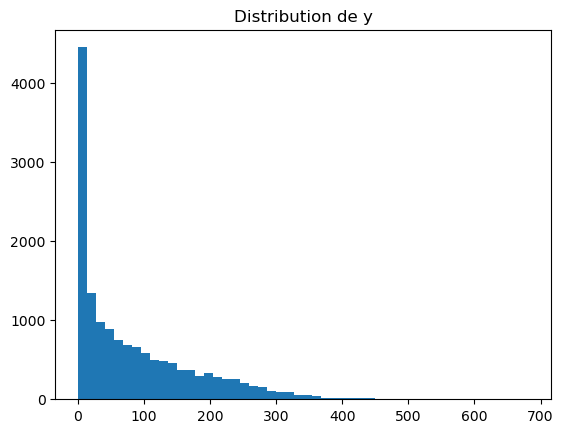

In [64]:
plt.hist(y, bins=50)
plt.title("Distribution de y")
plt.show()

In [43]:
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.ensemble import RandomForestRegressor # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore

# Séparer les données
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42) 

# Initialiser le modèle Random Forest
rf_model2 = RandomForestRegressor(n_estimators=100, random_state=42, verbose=1) #, max_depth=10, n_jobs=-1 après estimator pour profondeur des arbres 
                                                                            # et utilisations de tous les coeurs en parallèle
# Entraîner le modèle Random Forest
rf_model2.fit(X_train2, y_train2)

# Faire des prédictions sur l'ensemble de test
y_pred_rf2 = rf_model2.predict(X_test2)

# Évaluer la performance
mae_rf2 = mean_absolute_error(y_test2, y_pred_rf2)
rmse_rf2 = np.sqrt(mean_squared_error(y_test2, y_pred_rf2))
# Calculer le coefficient de détermination R²
r2_rf2 = r2_score(y_test2, y_pred_rf2)

print(f"Random Forest - Mean Absolute Error (MAE) : {mae_rf2}")
print(f"Random Forest - Root Mean Squared Error (RMSE) : {rmse_rf2}")
print(f"Random Forest - Coefficient de détermination (R²) : {r2_rf2}")

# Calculer le Mean Absolute Percentage Error (MAPE)
mape_rf2 = np.mean(np.abs((y_test2 - y_pred_rf2) / y_test2)) * 100

print(f"Random Forest - Mean Absolute Percentage Error (MAPE)  : {mape_rf2:.2f}%")

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
y_test_filtered_rf2 = y_test2[y_test2 > 0]
y_pred_filtered_rf2 = y_pred_rf2[y_test2 > 0]

# Calcul du MAPE avec les valeurs filtrées
mape_filtered_rf2 = np.mean(np.abs((y_test_filtered_rf2 - y_pred_filtered_rf2) / y_test_filtered_rf2)) * 100
print(f"Random Forest - Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {mape_filtered_rf2:.2f}%")


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s


Random Forest - Mean Absolute Error (MAE) : 25.775376588553403
Random Forest - Root Mean Squared Error (RMSE) : 50.256862177830754
Random Forest - Coefficient de détermination (R²) : 0.9736361368047018
Random Forest - Mean Absolute Percentage Error (MAPE)  : inf%
Random Forest - Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 46.63%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [44]:
# Copier X_test pour conserver les colonnes originales
df_rf_results = X_test.copy()  
# Ajouter les valeurs réelles
df_rf_results['y_test'] = y_test  
# Ajouter les prédictions
df_rf_results['y_pred'] = y_pred_rf
# Calculer l'erreur absolue 
df_rf_results['err-abs'] = abs(df_rf_results['y_test'] - df_rf_results['y_pred'])  

# Ajouter colonnes 'oveh' et 'abs-err' pour comparer avec les valeurs réelles
df_rf_results['oveh'] = df_maille_aggregee['oveh']
df_rf_results['abs-err'] = df_maille_aggregee['abs-err']
# Trié Dataframe par erreur absolue
df_rf_results = df_rf_results.sort_values(by='err-abs', ascending=False)
# Afficher un aperçu du DataFrame avec l'erreur absolue
df_rf_results.head(20)

,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err-abs,oveh,abs-err
9670,226,215.0,94.0,42.0,20.0,5.0,0.0,215.0,94.0,42.0,20.0,19.0,19.0,52.0,42.0,4.0,3.0,11.0,0.0,789.0,779.0,91.0,100.0,116.0,30.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,623.0,457.42,165.58,880.0,393.000000
9593,225,159.0,94.0,53.0,24.0,8.0,0.0,159.0,94.0,53.0,24.0,22.0,22.0,10.0,29.0,3.0,6.0,5.0,0.0,980.0,828.0,164.0,212.0,163.0,88.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,180.0,345.33,165.33,491.0,65.000000
7231,194,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,186.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,221.0,70.01,150.99,0.0,106.000000
9121,219,6.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,3.0,2.0,2.0,0.0,0.0,0.0,326.0,334.0,44.0,52.0,58.0,24.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,183.0,40.03,142.97,466.0,44.000000
7161,193,7.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,286.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,235.0,106.80,128.20,0.0,120.000000
6330,181,9.0,1.0,0.0,0.0,0.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,2.0,0.0,0.0,235.0,108.0,115.0,77.0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213.0,88.74,124.26,640.0,148.142857
3705,134,57.0,59.0,58.0,49.0,20.0,4.0,56.0,56.0,56.0,56.0,56.0,56.0,0.0,1.0,0.0,0.0,1.0,0.0,18.0,18.0,13.0,64.0,17.0,11.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,63.0,185.32,122.32,73.0,53.000000
9079,218,65.0,30.0,4.0,1.0,0.0,0.0,58.0,29.0,4.0,1.0,0.0,0.0,29.0,34.0,27.0,4.0,1.0,0.0,277.0,505.0,123.0,118.0,57.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,363.0,242.31,120.69,960.0,75.000000
2963,117,105.0,3.0,1.0,0.0,0.0,0.0,4.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,83.0,46.0,16.0,3.0,22.0,18.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,143.0,259.58,116.58,176.0,75.000000
7860,202,42.0,8

In [ ]:
# Copier X_test pour conserver les colonnes originales
df_rf_results2 = X_test2.copy()
# Ajouter les valeurs réelles  
df_rf_results2['y_test'] = y_test2
# Ajouter les prédictions 
df_rf_results2['y_pred'] = y_pred_rf2 
# Calculer l'erreur absolue
df_rf_results2['err-abs'] = abs(df_rf_results2['y_test'] - df_rf_results2['y_pred'])  

# Ajouter colonnes 'oveh' et 'abs-err' pour comparer avec les valeurs réelles
df_rf_results2['oveh'] = df_maille_aggregee2['oveh']
df_rf_results2['abs-err'] = df_maille_aggregee2['abs-err']
# Trier Dataframe par erreur absolue décroissante # 
df_rf_results2 = df_rf_results2.sort_values(by='err-abs', ascending=False)
# Afficher un aperçu du DataFrame avec l'erreur absolue
df_rf_results2.head(20)

,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err-abs,oveh,abs-err
5338,236,653.0,284.0,96.0,53.0,11.0,1.0,665.0,284.0,96.0,53.0,27.0,27.0,79.0,76.0,37.0,27.0,11.0,0.0,470.0,417.0,183.0,199.0,71.0,118.0,7,0,0,0,0,0,0,1,1934.0,1534.04,399.96,3364.0,1209.000000
2852,155,165.0,110.0,60.0,15.0,0.0,0.0,95.0,79.0,78.0,79.0,79.0,79.0,1.0,10.0,0.0,0.0,0.0,0.0,11.0,33.0,25.0,29.0,8.0,4.0,2,0,0,0,0,0,1,0,294.0,635.42,341.42,435.0,77.000000
4833,220,353.0,148.0,63.0,27.0,5.0,0.0,332.0,140.0,59.0,24.0,24.0,24.0,78.0,36.0,4.0,5.0,7.0,0.0,260.0,184.0,34.0,35.0,39.0,27.0,7,0,0,0,0,0,0,1,1329.0,990.14,338.86,2296.0,584.000000
4863,221,383.0,138.0,68.0,26.0,9.0,0.0,200.0,64.0,27.0,13.0,13.0,13.0,36.0,43.0,14.0,10.0,4.0,0.0,458.0,486.0,104.0,96.0,65.0,43.0,5,0,0,0,0,0,0,0,1291.0,952.31,338.69,2422.0,716.000000
5055,227,627.0,255.0,109.0,46.0,22.0,0.0,608.0,206.0,76.0,33.0,28.0,28.0,131.0,76.0,12.0,19.0,25.0,0.0,416.0,414.0,70.0,83.0,136.0,28.0,7,0,0,0,0,0,0,1,1932.0,1603.48,328.52,3198.0,1114.000000
4995,225,1648.0,1006.0,536.0,277.0,73.0,0.0,1643.0,897.0,487.0,248.0,225.0,225.0,200.0,203.0,54.0,77.0,52.0,0.0,980.0,828.0,164.0,212.0,163.0,88.0,9,0,0,0,0,0,0,1,2861.0,2545.33,315.67,4327.0,1814.000000
5247,233,823.0,472.0,219.0,117.0,32.0,0.0,823.0,352.0,176.0,93.0,60.0,60.0,115.0,140.0,17.0,23.0,15.0,0.0,700.0,957.0,93.0,141.0,88.0,118.0,5,0,0,0,0,0,0,1,1595.0,1880.98,285.98,2692.0,1019.000000
4699,215,833.0,506.0,221.0,77.0,15.0,0.0,2100.0,506.0,221.0,77.0,15.0,0.0,195.0,168.0,40.0,0.0,30.0,0.0,1622.0,915.0,249.0,0.0,200.0,0.0,5,0,0,0,0,0,0,0,1474.0,1757.36,283.36,2274.0,1641.714286
4677,215,406.0,154.0,84.0,30.0,7.0,0.0,254.0,100.0,47.0,24.0,23.0,24.0,68.0,52.0,22.0,12.0,0.0,0.0,554.0,405.0,117.0,48.0,64.0,105.0,4,0,0,0,0,0,0,0,1381.0,1106.61,274.39,2368.0,895.000000
3492,177,122.0,82.0,33.0,9.0,3.0,0.0,121.0,81.0,56.0,56.0,58.0,58.0,19.0,26.0,3.0,2.0,5.0,0.0,58.0,74.0,15.0,10.0,23.0,12.0,5,0,0,0,0,0,0,1,853.0,583.61,269.39,0.0,256.000000


In [48]:
# Exporter le DataFrame avec les résultats finaux
df_rf_results.to_excel("df_rf_results.xlsx", index=False)

In [49]:
# Exporter le DataFrame avec les résultats finaux
df_rf_results2.to_excel("df_rf_results2.xlsx", index=False)

### Recherche erreurs ###

In [50]:
# Filtrer les observations avec des erreurs absolues élevées
high_error_threshold = 100
df_high_errors = df_rf_results[df_rf_results['err-abs'] > high_error_threshold]

# Résumé statistique des observations à haute erreur
summary_high_errors = df_high_errors.describe()

# Nombre total de voyages avec des erreurs absolues élevées
num_high_errors = len(df_high_errors)

print(f"Nombre de voyages avec une erreur absolue > {high_error_threshold} : {num_high_errors}")
print("Résumé statistique des observations avec des erreurs élevées :")
summary_high_errors

Nombre de voyages avec une erreur absolue > 100 : 15
Résumé statistique des observations avec des erreurs élevées :


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err-abs,oveh,abs-err
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.00000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.00000,15.000000,15.000000,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.000000,15.0,15.0,15.0,15.0,15.0,15.0,15.000000,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.000000,15.0,15.0,15.000000,15.000000,15.0,15.0,15.000000,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.000000,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.000000,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.000000,15.000000,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,187.666667,62.733333,27.933333,14.533333,8.200000,2.800000,0.266667,59.533333,26.80000,14.133333,8.800000,7.800000,7.600000,15.800000,10.466667,4.733333,2.466667,2.266667,0.066667,328.333333,214.866667,74.066667,63.400000,35.60000,13.000000,1.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.0,0.066667,0.066667,0.0,0.0,0.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133333,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,256.600000,214.338000,126.130000,410.666667,188.600000
std,37.497936,61.972882,33.656811,20.773839,13.934541,5.387817,1.032796,66.870735,33.49243,20.482978,15.474403,15.311993,15.398516,17.941174,14.085792,7.657552,3.292126,3.473711,0.258199,359.725027,274.544263,106.954240,64.828124,48.17053,23.068222,0.507093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.258199,0.0,0.0,0.0,0.0,0.0,0.0,0.414039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.351866,0.0,0.0,0.258199,0.258199,0.0,0.0,0.351866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.258199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.258199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.351866,0.258199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.487950,128.735498,133.818672,20.712207,293.654235,132.653456
min,117.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,63.000000,40.030000,102.130000,0.000000,44.000000
25%,166.000000,9.500000,2.000000,0.000

In [51]:
df_high_errors = df_high_errors.sort_values(by='err-abs', ascending=False)
df_high_errors

,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err-abs,oveh,abs-err
9670,226,215.0,94.0,42.0,20.0,5.0,0.0,215.0,94.0,42.0,20.0,19.0,19.0,52.0,42.0,4.0,3.0,11.0,0.0,789.0,779.0,91.0,100.0,116.0,30.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,623.0,457.42,165.58,880.0,393.000000
9593,225,159.0,94.0,53.0,24.0,8.0,0.0,159.0,94.0,53.0,24.0,22.0,22.0,10.0,29.0,3.0,6.0,5.0,0.0,980.0,828.0,164.0,212.0,163.0,88.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,180.0,345.33,165.33,491.0,65.000000
7231,194,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,186.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,221.0,70.01,150.99,0.0,106.000000
9121,219,6.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,3.0,2.0,2.0,0.0,0.0,0.0,326.0,334.0,44.0,52.0,58.0,24.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,183.0,40.03,142.97,466.0,44.000000
7161,193,7.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,286.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,235.0,106.80,128.20,0.0,120.000000
6330,181,9.0,1.0,0.0,0.0,0.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,2.0,0.0,0.0,235.0,108.0,115.0,77.0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213.0,88.74,124.26,640.0,148.142857
3705,134,57.0,59.0,58.0,49.0,20.0,4.0,56.0,56.0,56.0,56.0,56.0,56.0,0.0,1.0,0.0,0.0,1.0,0.0,18.0,18.0,13.0,64.0,17.0,11.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,63.0,185.32,122.32,73.0,53.000000
9079,218,65.0,30.0,4.0,1.0,0.0,0.0,58.0,29.0,4.0,1.0,0.0,0.0,29.0,34.0,27.0,4.0,1.0,0.0,277.0,505.0,123.0,118.0,57.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,363.0,242.31,120.69,960.0,75.000000
2963,117,105.0,3.0,1.0,0.0,0.0,0.0,4.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,83.0,46.0,16.0,3.0,22.0,18.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,143.0,259.58,116.58,176.0,75.000000
7860,202,42.0,8

In [56]:
# Filtrer les observations avec des erreurs absolues élevées
high_error_threshold = 100
df_high_errors2 = df_rf_results2[df_rf_results2['err-abs'] > high_error_threshold]

# Résumé statistique des observations à haute erreur
summary_high_errors2 = df_high_errors2.describe()

# Nombre total de voyages avec des erreurs absolues élevées
num_high_errors2 = len(df_high_errors2)

print(f"Nombre de voyages avec une erreur absolue > {high_error_threshold} : {num_high_errors2}")
print("Résumé statistique des observations avec des erreurs élevées :")
summary_high_errors2

Nombre de voyages avec une erreur absolue > 100 : 81
Résumé statistique des observations avec des erreurs élevées :


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err-abs,oveh,abs-err
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.0,81.0,81.0,81.0,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,209.160494,288.716049,151.567901,71.271605,31.481481,8.148148,0.370370,432.881834,227.493827,76.393298,42.135802,26.172840,23.271605,67.740741,44.012346,15.962963,12.592593,7.938272,0.975309,401.074074,271.098765,97.296296,82.580247,73.246914,30.728395,4.851852,0.197531,0.0,0.0,0.0,0.0,0.148148,0.506173,890.987654,825.316420,173.025802,1512.740741,565.793651
std,32.362577,296.431874,175.198383,88.369255,43.382056,12.503111,1.770907,553.636147,550.058205,93.104661,61.547696,42.978713,44.390881,60.610597,50.485764,18.287594,15.366179,10.791601,3.368884,322.145339,260.902070,86.869650,72.717409,66.553274,36.592012,1.621042,0.400617,0.0,0.0,0.0,0.0,0.357460,0.503077,570.311044,521.566139,69.253359,1311.879575,448.183951
min,119.000000,29.000000,12.000000,5.000000,0.000000,0.000000,0.000000,8.000000,12.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,11.000000,13.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,101.000000,176.840000,102.360000,0.000000,30.000000
25%,184.000000,86.000000,41.000000,16.000000,5.000000,0.000000,0.000000,95.000000,43.000000,17.000000,10.000000,4.000000,0.000000,22.000000,11.000000,3.000000,2.000000,0.000000,0.000000,150.000000,72.000000,31.000000,33.000000,28.000000,0.000000,4.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,437.000000,396.990000,122.350000,742.000000,227.000000
50%,215.000000,198.000000,99.000000,46.000000,17.000000,4.000000,0.000000,231.000000,96.000000,44.714286,22.000000,12.000000,5.000000,44.000000,26.000000,9.000000,6.000000,3.000000,0.000000,313.000000,174.000000,72.000000,64.000000,69.000000,16.000000,5.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.000000,742.000000,631.140000,148.570000,1294.000000,456.000000
75%,231.000000,353.000000,162.000000,83.000000,37.000000,11.000000,0.000000,500.571429,242.000000,83.000000,51.000000,28.000000,25.000000,90.000000,52.000000,20.000000,19.000000,11.000000,0.000000,589.000000,405.000000,142.000000,115.000000,95.000000,47.000000,6.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.000000,1270.000000,1150.140000,193.670000,2274.000000,773.571429
max,300.000000,1648.000000,1006.000000,536.000000,277.000000,73.000000,15.000000,3206.571429,4795.571429,487.000000,407.000000,225.000000,225.000000,241.000000,203.000000,88.000000,77.000000,52.000000,21.000000,1622.000000,957.000000,408.000000,447.000000,458.000000,147.000000,9.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,2861.000000,2545.330000,399.960000,7880.000000,1881.000000


In [57]:
df_high_errors2 = df_high_errors2.sort_values(by='err-abs', ascending=False)
df_high_errors2

,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err-abs,oveh,abs-err
5338,236,653.0,284.0,96.0,53.0,11.0,1.0,665.000000,284.000000,96.000000,53.0,27.0,27.0,79.0,76.0,37.0,27.0,11.0,0.0,470.0,417.0,183.0,199.0,71.0,118.0,7,0,0,0,0,0,0,1,1934.0,1534.04,399.96,3364.0,1209.000000
2852,155,165.0,110.0,60.0,15.0,0.0,0.0,95.000000,79.000000,78.000000,79.0,79.0,79.0,1.0,10.0,0.0,0.0,0.0,0.0,11.0,33.0,25.0,29.0,8.0,4.0,2,0,0,0,0,0,1,0,294.0,635.42,341.42,435.0,77.000000
4833,220,353.0,148.0,63.0,27.0,5.0,0.0,332.000000,140.000000,59.000000,24.0,24.0,24.0,78.0,36.0,4.0,5.0,7.0,0.0,260.0,184.0,34.0,35.0,39.0,27.0,7,0,0,0,0,0,0,1,1329.0,990.14,338.86,2296.0,584.000000
4863,221,383.0,138.0,68.0,26.0,9.0,0.0,200.000000,64.000000,27.000000,13.0,13.0,13.0,36.0,43.0,14.0,10.0,4.0,0.0,458.0,486.0,104.0,96.0,65.0,43.0,5,0,0,0,0,0,0,0,1291.0,952.31,338.69,2422.0,716.000000
5055,227,627.0,255.0,109.0,46.0,22.0,0.0,608.000000,206.000000,76.000000,33.0,28.0,28.0,131.0,76.0,12.0,19.0,25.0,0.0,416.0,414.0,70.0,83.0,136.0,28.0,7,0,0,0,0,0,0,1,1932.0,1603.48,328.52,3198.0,1114.000000
4995,225,1648.0,1006.0,536.0,277.0,73.0,0.0,1643.000000,897.000000,487.000000,248.0,225.0,225.0,200.0,203.0,54.0,77.0,52.0,0.0,980.0,828.0,164.0,212.0,163.0,88.0,9,0,0,0,0,0,0,1,2861.0,2545.33,315.67,4327.0,1814.000000
5247,233,823.0,472.0,219.0,117.0,32.0,0.0,823.000000,352.000000,176.000000,93.0,60.0,60.0,115.0,140.0,17.0,23.0,15.0,0.0,700.0,957.0,93.0,141.0,88.0,118.0,5,0,0,0,0,0,0,1,1595.0,1880.98,285.98,2692.0,1019.000000
4699,215,833.0,506.0,221.0,77.0,15.0,0.0,2100.000000,506.000000,221.000000,77.0,15.0,0.0,195.0,168.0,40.0,0.0,30.0,0.0,1622.0,915.0,249.0,0.0,200.0,0.0,5,0,0,0,0,0,0,0,1474.0,1757.36,283.36,2274.0,1641.714286
4677,215,406.0,154.0,84.0,30.0,7.0,0.0,254.000000,100.000000,47.000000,24.0,23.0,24.0,68.0,52.0,22.0,12.0,0.0,0.0,554.0,405.0,117.0,48.0,64.0,105.0,4,0,0,0,0,0,0,0,1381.0,1106.61,274.39,2368.0,895.000000
3492,177,122.0,82.0,33.0,9.0,3.0,0.0,121.000000,81.000000,56.000000,56.0,58.0,58.0,19.0,26.0,3.0,2.0,5.0,0.0,58.0,74.0,15.0,10.0,23.0,12.0,5,0,0,0,0,0,0,1,853.0,583.61,269.39,0.0,256.000000


### RandomizedSearch ###

In [58]:
# RandomizedSearch
from sklearn.model_selection import RandomizedSearchCV # type: ignore
from sklearn.ensemble import RandomForestRegressor # type: ignore
from scipy.stats import randint # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore

# Définir la grille de paramètres pour RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(10, 100),  # Limiter le nombre d'arbres
    'max_depth': [None, 10, 20, 30],  # Limiter la profondeur
    'max_features': ['sqrt', 'log2'],  # Contrôler le nombre de variables
}

# Initialiser RandomForest avec RandomizedSearch
model_opti = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(model_opti, param_distributions, n_iter=20, cv=3, n_jobs=-1, verbose=1)
random_search.fit(X, y)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres trouvés :", random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Meilleurs paramètres trouvés : {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 85}


In [59]:
# RandomizedSearch
from sklearn.model_selection import RandomizedSearchCV # type: ignore
from sklearn.ensemble import RandomForestRegressor # type: ignore
from scipy.stats import randint # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore

# Définir la grille de paramètres pour RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(10, 100),  # Limiter le nombre d'arbres
    'max_depth': [None, 10, 20, 30],  # Limiter la profondeur
    'max_features': ['sqrt', 'log2'],  # Contrôler le nombre de variables
}

# Initialiser RandomForest avec RandomizedSearch
model_opti2 = RandomForestRegressor(random_state=42)
random_search2 = RandomizedSearchCV(model_opti2, param_distributions, n_iter=20, cv=3, n_jobs=-1, verbose=1)
random_search2.fit(X2, y2)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres trouvés :", random_search2.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Meilleurs paramètres trouvés : {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 67}


In [60]:
from sklearn.model_selection import train_test_split # type: ignore

# Séparer les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser le modèle Random Forest avec les meilleurs paramètres
model_opti = RandomForestRegressor(
    n_estimators=85,  # Meilleur nombre d'arbres
    max_depth=30,     # Meilleure profondeur d'arbres
    max_features='sqrt',  # Meilleure sélection des caractéristiques
    random_state=42,
    verbose=1  # Activer les logs pour vérifier l'entraînement
)

# Entraîner le modèle Random Forest
model_opti.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_opti = model_opti.predict(X_test)

# Évaluer la performance
mae_opti = mean_absolute_error(y_test, y_pred_opti)
rmse_opti = np.sqrt(mean_squared_error(y_test, y_pred_opti))
r2_opti = r2_score(y_test, y_pred_opti)

print(f"Random Forest - Mean Absolute Error (MAE) : {mae_opti}")
print(f"Random Forest - Root Mean Squared Error (RMSE) : {rmse_opti}")
print(f"Random Forest - Coefficient de détermination (R²) : {r2_opti}")

# Calculer le Mean Absolute Percentage Error (MAPE)
mape_opti = np.mean(np.abs((y_test - y_pred_opti) / y_test)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
y_test_filtered_opti = y_test[y_test > 0]
y_pred_filtered_opti = y_pred_opti[y_test > 0]

# Calcul du MAPE avec les valeurs filtrées
mape_filtered_opti = np.mean(np.abs((y_test_filtered_opti - y_pred_filtered_opti) / y_test_filtered_opti)) * 100
print(f"Random Forest - Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {mape_filtered_opti:.2f}%")

# Créer un DataFrame pour afficher les résultats finaux
df_rf_opti = X_test.copy()  # Copier X_test pour conserver les colonnes originales
df_rf_opti['y_test'] = y_test  # Ajouter les valeurs réelles
df_rf_opti['y_pred'] = y_pred_opti  # Ajouter les prédictions
df_rf_opti['err-abs'] = abs(df_rf_opti['y_test'] - df_rf_opti['y_pred'])  # Calculer l'erreur absolue

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


Random Forest - Mean Absolute Error (MAE) : 16.129568597233824
Random Forest - Root Mean Squared Error (RMSE) : 25.079691633843925
Random Forest - Coefficient de détermination (R²) : 0.9270284878212999
Random Forest - Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 55.63%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [61]:
from sklearn.model_selection import train_test_split # type: ignore

# Séparer les données
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Initialiser le modèle Random Forest avec les meilleurs paramètres
model_opti2 = RandomForestRegressor(
    n_estimators=70,  # Meilleur nombre d'arbres
    max_depth=30,     # Meilleure profondeur d'arbres
    max_features='log2',  # Meilleure sélection des caractéristiques
    random_state=42,
    verbose=1  # Activer les logs pour vérifier l'entraînement
)

# Entraîner le modèle Random Forest
model_opti2.fit(X_train2, y_train2)

# Faire des prédictions sur l'ensemble de test
y_pred_opti2 = model_opti2.predict(X_test2)

# Évaluer la performance
mae_opti2 = mean_absolute_error(y_test2, y_pred_opti2)
rmse_opti2 = np.sqrt(mean_squared_error(y_test2, y_pred_opti2))
r2_opti2 = r2_score(y_test2, y_pred_opti2)

print(f"Random Forest - Mean Absolute Error (MAE) : {mae_opti2}")
print(f"Random Forest - Root Mean Squared Error (RMSE) : {rmse_opti2}")
print(f"Random Forest - Coefficient de détermination (R²) : {r2_opti2}")

# Calculer le Mean Absolute Percentage Error (MAPE)
mape_opti2 = np.mean(np.abs((y_test2 - y_pred_opti2) / y_test2)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
y_test_filtered_opti2 = y_test2[y_test2 > 0]
y_pred_filtered_opti2 = y_pred_opti2[y_test2 > 0]

# Calcul du MAPE avec les valeurs filtrées
mape_filtered_opti2 = np.mean(np.abs((y_test_filtered_opti2 - y_pred_filtered_opti2) / y_test_filtered_opti2)) * 100
print(f"Random Forest - Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {mape_filtered_opti2:.2f}%")

# Créer un DataFrame pour afficher les résultats finaux
df_rf_opti2 = X_test2.copy()  # Copier X_test pour conserver les colonnes originales
df_rf_opti2['y_test'] = y_test2  # Ajouter les valeurs réelles
df_rf_opti2['y_pred'] = y_pred_opti2  # Ajouter les prédictions
df_rf_opti2['err-abs'] = abs(df_rf_opti2['y_test'] - df_rf_opti2['y_pred'])  # Calculer l'erreur absolue

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s


Random Forest - Mean Absolute Error (MAE) : 28.48102763427662
Random Forest - Root Mean Squared Error (RMSE) : 56.94608443693413
Random Forest - Coefficient de détermination (R²) : 0.9661509841991861
Random Forest - Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 52.37%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [65]:
# Trié Dataframe par erreur absolue
df_rf_opti = df_rf_opti.sort_values(by='err-abs', ascending=False)
# Afficher un aperçu du DataFrame avec l'erreur absolue
df_rf_opti.head(20)

,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err-abs
9670,226,215.0,94.0,42.0,20.0,5.0,0.0,215.0,94.0,42.0,20.0,19.0,19.0,52.0,42.0,4.0,3.0,11.0,0.0,789.0,779.0,91.0,100.0,116.0,30.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,623.0,417.658824,205.341176
9593,225,159.0,94.0,53.0,24.0,8.0,0.0,159.0,94.0,53.0,24.0,22.0,22.0,10.0,29.0,3.0,6.0,5.0,0.0,980.0,828.0,164.0,212.0,163.0,88.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,180.0,337.270588,157.270588
7231,194,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,186.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,221.0,69.323417,151.676583
4735,155,155.0,95.0,42.0,20.0,0.0,0.0,149.0,110.0,107.0,110.0,110.0,110.0,10.0,19.0,7.0,2.0,0.0,0.0,126.0,137.0,108.0,58.0,37.0,22.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,489.0,339.788235,149.211765
9507,224,190.0,77.0,28.0,15.0,9.0,0.0,190.0,77.0,28.0,15.0,15.0,15.0,34.0,17.0,4.0,5.0,0.0,0.0,585.0,311.0,71.0,130.0,45.0,30.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,524.0,380.141176,143.858824
7860,202,42.0,8.0,2.0,0.0,0.0,0.0,146.0,8.0,2.0,0.0,0.0,0.0,39.0,2.0,3.0,2.0,0.0,0.0,1168.0,176.0,408.0,160.0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,332.0,194.152941,137.847059
9121,219,6.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,3.0,2.0,2.0,0.0,0.0,0.0,326.0,334.0,44.0,52.0,58.0,24.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,183.0,47.505882,135.494118
6330,181,9.0,1.0,0.0,0.0,0.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,2.0,0.0,0.0,235.0,108.0,115.0,77.0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213.0,79.576471,133.423529
8478,210,113.0,37.0,11.0,0.0,0.0,0.0,529.0,37.0,11.0,0.0,0.0,0.0,33.0,30.0,6.0,0.0,0.0,0.0,798.0,362.0,157.0,0.0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,414.0,285.352941,128.647059
6331,181,10.0,7.0,1.0,0.0,0.0,0.0,2.0,7.0,1.0,0.0,0.0,0.0,6.

In [66]:
# Trié Dataframe par erreur absolue
df_rf_opti2 = df_rf_opti2.sort_values(by='err-abs', ascending=False)
# Afficher un aperçu du DataFrame avec l'erreur absolue
df_rf_opti2.head(20)

,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err-abs
5338,236,653.0,284.0,96.0,53.0,11.0,1.0,665.000000,284.000000,96.0,53.0,27.0,27.0,79.0,76.0,37.0,27.0,11.0,0.0,470.0,417.0,183.0,199.0,71.0,118.0,7,0,0,0,0,0,0,1,1934.0,1448.985714,485.014286
4487,209,327.0,114.0,67.0,25.0,4.0,0.0,212.000000,72.000000,41.0,25.0,25.0,25.0,74.0,29.0,8.0,7.0,0.0,0.0,491.0,223.0,72.0,77.0,85.0,107.0,6,0,0,0,0,0,0,0,1413.0,978.485714,434.514286
4995,225,1648.0,1006.0,536.0,277.0,73.0,0.0,1643.000000,897.000000,487.0,248.0,225.0,225.0,200.0,203.0,54.0,77.0,52.0,0.0,980.0,828.0,164.0,212.0,163.0,88.0,9,0,0,0,0,0,0,1,2861.0,2431.014286,429.985714
4863,221,383.0,138.0,68.0,26.0,9.0,0.0,200.000000,64.000000,27.0,13.0,13.0,13.0,36.0,43.0,14.0,10.0,4.0,0.0,458.0,486.0,104.0,96.0,65.0,43.0,5,0,0,0,0,0,0,0,1291.0,890.457143,400.542857
5055,227,627.0,255.0,109.0,46.0,22.0,0.0,608.000000,206.000000,76.0,33.0,28.0,28.0,131.0,76.0,12.0,19.0,25.0,0.0,416.0,414.0,70.0,83.0,136.0,28.0,7,0,0,0,0,0,0,1,1932.0,1541.028571,390.971429
4774,218,1256.0,691.0,392.0,177.0,39.0,0.0,1091.000000,606.000000,346.0,185.0,185.0,185.0,169.0,201.0,42.0,49.0,33.0,0.0,655.0,677.0,120.0,175.0,95.0,77.0,8,0,0,0,0,0,0,1,2478.0,2091.657143,386.342857
4833,220,353.0,148.0,63.0,27.0,5.0,0.0,332.000000,140.000000,59.0,24.0,24.0,24.0,78.0,36.0,4.0,5.0,7.0,0.0,260.0,184.0,34.0,35.0,39.0,27.0,7,0,0,0,0,0,0,1,1329.0,986.557143,342.442857
5510,242,495.0,254.0,87.0,43.0,17.0,0.0,490.000000,165.000000,58.0,35.0,19.0,19.0,108.0,56.0,20.0,2.0,20.0,0.0,341.0,335.0,113.0,42.0,93.0,46.0,5,0,0,0,0,0,0,1,1537.0,1209.471429,327.528571
4677,215,406.0,154.0,84.0,30.0,7.0,0.0,254.000000,100.000000,47.0,24.0,23.0,24.0,68.0,52.0,22.0,12.0,0.0,0.0,554.0,405.0,117.0,48.0,64.0,105.0,4,0,0,0,0,0,0,0,1381.0,1059.742857,321.257143
3492,177,122.0,82.0,33.0,9.0,3.0,0.0,121.000000,81.000000,56.0,56.0,58.0,58.0,19.0,26.0,3.0,2.0,5.0,0.0,58.0,74.0,15.0,10.0,23.0,12.0,5,0,0,0,0,0,0,1,853.0,531.885714,321.114286


In [ ]:
# Exporter le DataFrame avec les résultats finaux
df_rf_opti2.to_excel("df_rf_opti.xlsx", index=False)

In [ ]:
# Exporter le DataFrame avec les résultats finaux
df_rf_opti2.to_excel("df_rf_opti2.xlsx", index=False)

### Grid Search ###

In [67]:
# Grid Search
from sklearn.model_selection import GridSearchCV # type: ignore
from sklearn.ensemble import RandomForestRegressor # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore

# Définir la grille de paramètres pour GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100],  # Nombre d'arbres
    'max_depth': [None, 10, 20],  # Profondeur des arbres
    'max_features': ['sqrt', 'log2'],  # Sélection des caractéristiques
}

# Initialiser RandomForest avec GridSearch
model_grid = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(model_grid, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X, y)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres trouvés :", grid_search.best_params_)
# Afficher le meilleur score
print("Meilleur score :", grid_search.best_score_)
# Afficher le meilleur estimateur
print("Meilleur estimateur :", grid_search.best_estimator_)
# Afficher les résultats complets   
print("Résultats complets :", grid_search.cv_results_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Meilleurs paramètres trouvés : {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
Meilleur score : 0.7254675120771901
Meilleur estimateur : RandomForestRegressor(max_features='sqrt', random_state=42)
Résultats complets : {'mean_fit_time': array([0.43483011, 1.88384565, 3.77578219, 0.42815359, 1.71011806,
       3.39189068, 0.18937453, 0.84394193, 1.60012809, 0.15008609,
       0.56635404, 1.01949231, 0.38144867, 1.61151814, 2.93941474,
       0.28279193, 1.23703424, 2.14110629]), 'std_fit_time': array([0.06351035, 0.27514481, 0.53675265, 0.01643423, 0.20014682,
       0.29272688, 0.0100055 , 0.05401306, 0.13122128, 0.00638074,
       0.06807629, 0.02710084, 0.03860463, 0.12800398, 0.05256703,
       0.04032135, 0.06582328, 0.12751581]), 'mean_score_time': array([0.028011  , 0.09298086, 0.16625428, 0.03405722, 0.08689419,
       0.20019794, 0.018538  , 0.04145543, 0.06980896, 0.01673937,
       0.05038929, 0.0635

In [68]:
# Grid Search
from sklearn.model_selection import GridSearchCV # type: ignore
from sklearn.ensemble import RandomForestRegressor # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore

# Définir la grille de paramètres pour GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100],  # Nombre d'arbres
    'max_depth': [None, 10, 20],  # Profondeur des arbres
    'max_features': ['sqrt', 'log2'],  # Sélection des caractéristiques
}

# Initialiser RandomForest avec GridSearch
model_grid2 = RandomForestRegressor(random_state=42)
grid_search2 = GridSearchCV(model_grid2, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search2.fit(X2, y2)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres trouvés :", grid_search2.best_params_)
# Afficher le meilleur score
print("Meilleur score :", grid_search2.best_score_)
# Afficher le meilleur estimateur
print("Meilleur estimateur :", grid_search2.best_estimator_)
# Afficher les résultats complets   
print("Résultats complets :", grid_search2.cv_results_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Meilleurs paramètres trouvés : {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}
Meilleur score : 0.7887552274653452
Meilleur estimateur : RandomForestRegressor(max_depth=20, max_features='sqrt', random_state=42)
Résultats complets : {'mean_fit_time': array([0.17811378, 0.80977496, 1.64402199, 0.1813964 , 0.75598971,
       1.59117929, 0.09248567, 0.46328449, 0.88704689, 0.09032154,
       0.43275714, 0.78339251, 0.1604325 , 0.64959359, 1.1644241 ,
       0.13913345, 0.71353769, 1.14104724]), 'std_fit_time': array([0.02182885, 0.04294422, 0.01956711, 0.02534752, 0.03244724,
       0.06800512, 0.00469789, 0.022647  , 0.0481694 , 0.00436825,
       0.01388498, 0.05359933, 0.00912085, 0.06532526, 0.141976  ,
       0.02410158, 0.016492  , 0.09617943]), 'mean_score_time': array([0.02293976, 0.03038812, 0.05215128, 0.02007016, 0.03029339,
       0.0497392 , 0.00751495, 0.01749492, 0.03459938, 0.00656009,
       0.0190

In [69]:
from sklearn.model_selection import train_test_split # type: ignore

# Séparer les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser le modèle Random Forest avec les meilleurs paramètres
model_grid = RandomForestRegressor(
    n_estimators=100,  # Meilleur nombre d'arbres
    max_depth=None,     # Meilleure profondeur d'arbres
    max_features='sqrt',  # Meilleure sélection des caractéristiques
    random_state=42,
    verbose=1  # Activer les logs pour vérifier l'entraînement
)

# Entraîner le modèle Random Forest
model_grid.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_grid = model_grid.predict(X_test)

# Évaluer la performance
mae_grid = mean_absolute_error(y_test, y_pred_grid)
rmse_grid = np.sqrt(mean_squared_error(y_test, y_pred_grid))
r2_grid = r2_score(y_test, y_pred_grid)

print(f"Random Forest - Mean Absolute Error (MAE) : {mae_grid}")
print(f"Random Forest - Root Mean Squared Error (RMSE) : {rmse_grid}")
print(f"Random Forest - Coefficient de détermination (R²) : {r2_grid}")

# Calculer le Mean Absolute Percentage Error (MAPE)
mape_grid = np.mean(np.abs((y_test - y_pred_grid) / y_test)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
y_test_filtered = y_test[y_test > 0]
y_pred_filtered = y_pred_grid[y_test > 0]

# Calcul du MAPE avec les valeurs filtrées
mape_filtered_grid = np.mean(np.abs((y_test_filtered - y_pred_filtered) / y_test_filtered)) * 100
print(f"Random Forest - Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {mape_filtered_grid:.2f}%")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


Random Forest - Mean Absolute Error (MAE) : 15.932988178432769
Random Forest - Root Mean Squared Error (RMSE) : 25.11492600306446
Random Forest - Coefficient de détermination (R²) : 0.9268233089611682
Random Forest - Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 53.32%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [70]:
from sklearn.model_selection import train_test_split # type: ignore

# Séparer les données
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Initialiser le modèle Random Forest avec les meilleurs paramètres
model_grid2 = RandomForestRegressor(
    n_estimators=100,  # Meilleur nombre d'arbres
    max_depth=20,     # Meilleure profondeur d'arbres
    max_features='sqrt',  # Meilleure sélection des caractéristiques
    random_state=42,
    verbose=1  # Activer les logs pour vérifier l'entraînement
)

# Entraîner le modèle Random Forest
model_grid2.fit(X_train2, y_train2)

# Faire des prédictions sur l'ensemble de test
y_pred_grid2 = model_grid2.predict(X_test2)

# Évaluer la performance
mae_grid2 = mean_absolute_error(y_test2, y_pred_grid2)
rmse_grid2 = np.sqrt(mean_squared_error(y_test2, y_pred_grid2))
r2_grid2 = r2_score(y_test2, y_pred_grid2)

print(f"Random Forest - Mean Absolute Error (MAE) : {mae_grid2}")
print(f"Random Forest - Root Mean Squared Error (RMSE) : {rmse_grid2}")
print(f"Random Forest - Coefficient de détermination (R²) : {r2_grid2}")

# Calculer le Mean Absolute Percentage Error (MAPE)
mape_grid2 = np.mean(np.abs((y_test2 - y_pred_grid2) / y_test2)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
y_test_filtered2 = y_test2[y_test2 > 0]
y_pred_filtered2 = y_pred_grid2[y_test2 > 0]

# Calcul du MAPE avec les valeurs filtrées
mape_filtered_grid2= np.mean(np.abs((y_test_filtered2 - y_pred_filtered2) / y_test_filtered2)) * 100
print(f"Random Forest - Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {mape_filtered_grid2:.2f}%")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s


Random Forest - Mean Absolute Error (MAE) : 28.539814496128024
Random Forest - Root Mean Squared Error (RMSE) : 56.75801612972606
Random Forest - Coefficient de détermination (R²) : 0.9663741923516724
Random Forest - Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 51.85%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [71]:
# Créer un DataFrame pour afficher les résultats
df_grid_results = X_test.copy()  # Copier X_test pour conserver les colonnes originales
df_grid_results['y_test'] = y_test  # Ajouter les valeurs réelles
df_grid_results['y_pred'] = y_pred_grid  # Ajouter les prédictions
df_grid_results['err-abs'] = abs(df_grid_results['y_test'] - df_grid_results['y_pred'])  # Calculer l'erreur absolue

# Trié Dataframe par erreur absolue
df_grid_results = df_grid_results.sort_values(by='err-abs', ascending=False)
# Afficher un aperçu du DataFrame avec l'erreur absolue
df_grid_results.head(20)

,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err-abs
9670,226,215.0,94.0,42.0,20.0,5.0,0.0,215.0,94.0,42.0,20.0,19.0,19.0,52.0,42.0,4.0,3.0,11.0,0.0,789.0,779.0,91.0,100.0,116.0,30.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,623.0,397.61,225.39
9593,225,159.0,94.0,53.0,24.0,8.0,0.0,159.0,94.0,53.0,24.0,22.0,22.0,10.0,29.0,3.0,6.0,5.0,0.0,980.0,828.0,164.0,212.0,163.0,88.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,180.0,351.65,171.65
9507,224,190.0,77.0,28.0,15.0,9.0,0.0,190.0,77.0,28.0,15.0,15.0,15.0,34.0,17.0,4.0,5.0,0.0,0.0,585.0,311.0,71.0,130.0,45.0,30.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,524.0,367.32,156.68
4735,155,155.0,95.0,42.0,20.0,0.0,0.0,149.0,110.0,107.0,110.0,110.0,110.0,10.0,19.0,7.0,2.0,0.0,0.0,126.0,137.0,108.0,58.0,37.0,22.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,489.0,337.57,151.43
9121,219,6.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,3.0,2.0,2.0,0.0,0.0,0.0,326.0,334.0,44.0,52.0,58.0,24.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,183.0,41.91,141.09
3620,132,87.0,57.0,27.0,14.0,3.0,0.0,87.0,57.0,27.0,14.0,3.0,0.0,0.0,17.0,17.0,11.0,8.0,0.0,0.0,120.0,96.0,50.0,34.0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,342.0,203.01,138.99
7860,202,42.0,8.0,2.0,0.0,0.0,0.0,146.0,8.0,2.0,0.0,0.0,0.0,39.0,2.0,3.0,2.0,0.0,0.0,1168.0,176.0,408.0,160.0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,332.0,193.03,138.97
7231,194,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,186.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,221.0,86.80,134.20
6330,181,9.0,1.0,0.0,0.0,0.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,2.0,0.0,0.0,235.0,108.0,115.0,77.0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213.0,80.82,132.18
9025,217,237.0,92.0,33.0,7.0,0.0,0.0,1142.0,92.0,33.0,7.0,0.0,0.0,45.0,53.0,14.0,0.0,0.0,0.0,840.0,1001.0,246.0,0.0,0.0,0.0,2,0,0,0,

In [72]:
# Créer un DataFrame pour afficher les résultats
df_grid_results2 = X_test2.copy()  # Copier X_test pour conserver les colonnes originales
df_grid_results2['y_test'] = y_test2  # Ajouter les valeurs réelles
df_grid_results2['y_pred'] = y_pred_grid2  # Ajouter les prédictions
df_grid_results2['err-abs'] = abs(df_grid_results2['y_test'] - df_grid_results2['y_pred'])  # Calculer l'erreur absolue

# Trié Dataframe par erreur absolue
df_grid_results2 = df_grid_results2.sort_values(by='err-abs', ascending=False)
# Afficher un aperçu du DataFrame avec l'erreur absolue
df_grid_results2.head(20)

,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err-abs
5338,236,653.0,284.0,96.0,53.0,11.0,1.0,665.000000,284.0,96.0,53.0,27.0,27.0,79.0,76.0,37.0,27.0,11.0,0.0,470.0,417.0,183.0,199.0,71.0,118.0,7,0,0,0,0,0,0,1,1934.0,1355.910000,578.090000
5055,227,627.0,255.0,109.0,46.0,22.0,0.0,608.000000,206.0,76.0,33.0,28.0,28.0,131.0,76.0,12.0,19.0,25.0,0.0,416.0,414.0,70.0,83.0,136.0,28.0,7,0,0,0,0,0,0,1,1932.0,1509.710000,422.290000
4487,209,327.0,114.0,67.0,25.0,4.0,0.0,212.000000,72.0,41.0,25.0,25.0,25.0,74.0,29.0,8.0,7.0,0.0,0.0,491.0,223.0,72.0,77.0,85.0,107.0,6,0,0,0,0,0,0,0,1413.0,1011.080000,401.920000
4995,225,1648.0,1006.0,536.0,277.0,73.0,0.0,1643.000000,897.0,487.0,248.0,225.0,225.0,200.0,203.0,54.0,77.0,52.0,0.0,980.0,828.0,164.0,212.0,163.0,88.0,9,0,0,0,0,0,0,1,2861.0,2467.300000,393.700000
4774,218,1256.0,691.0,392.0,177.0,39.0,0.0,1091.000000,606.0,346.0,185.0,185.0,185.0,169.0,201.0,42.0,49.0,33.0,0.0,655.0,677.0,120.0,175.0,95.0,77.0,8,0,0,0,0,0,0,1,2478.0,2106.850000,371.150000
4677,215,406.0,154.0,84.0,30.0,7.0,0.0,254.000000,100.0,47.0,24.0,23.0,24.0,68.0,52.0,22.0,12.0,0.0,0.0,554.0,405.0,117.0,48.0,64.0,105.0,4,0,0,0,0,0,0,0,1381.0,1030.327500,350.672500
4863,221,383.0,138.0,68.0,26.0,9.0,0.0,200.000000,64.0,27.0,13.0,13.0,13.0,36.0,43.0,14.0,10.0,4.0,0.0,458.0,486.0,104.0,96.0,65.0,43.0,5,0,0,0,0,0,0,0,1291.0,941.450000,349.550000
4833,220,353.0,148.0,63.0,27.0,5.0,0.0,332.000000,140.0,59.0,24.0,24.0,24.0,78.0,36.0,4.0,5.0,7.0,0.0,260.0,184.0,34.0,35.0,39.0,27.0,7,0,0,0,0,0,0,1,1329.0,992.880000,336.120000
5510,242,495.0,254.0,87.0,43.0,17.0,0.0,490.000000,165.0,58.0,35.0,19.0,19.0,108.0,56.0,20.0,2.0,20.0,0.0,341.0,335.0,113.0,42.0,93.0,46.0,5,0,0,0,0,0,0,1,1537.0,1206.050000,330.950000
4711,216,255.0,86.0,44.0,18.0,5.0,0.0,170.000000,55.0,27.0,14.0,14.0,14.0,38.0,29.0,5.0,15.0,3.0,0.0,357.0,126.0,56.0,62.0,20.0,32.0,4,0,0,0,0,0,0,1,1014.0,724.100000,289.900000


In [ ]:
# Exporter le DataFrame avec les résultats finaux
df_grid_results.to_excel("df_results_final_grid.xlsx", index=False)

In [ ]:
# Exporter le DataFrame avec les résultats finaux
df_grid_results2.to_excel("df_results_final_grid2.xlsx", index=False)

### Visualisation ###

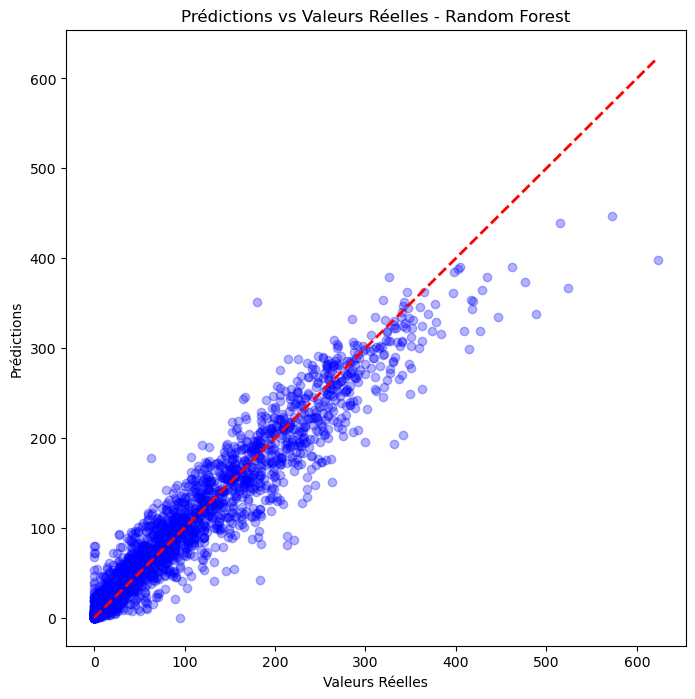

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_grid, alpha=0.3, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valeurs Réelles")
plt.ylabel("Prédictions")
plt.title("Prédictions vs Valeurs Réelles - Random Forest")
plt.show()

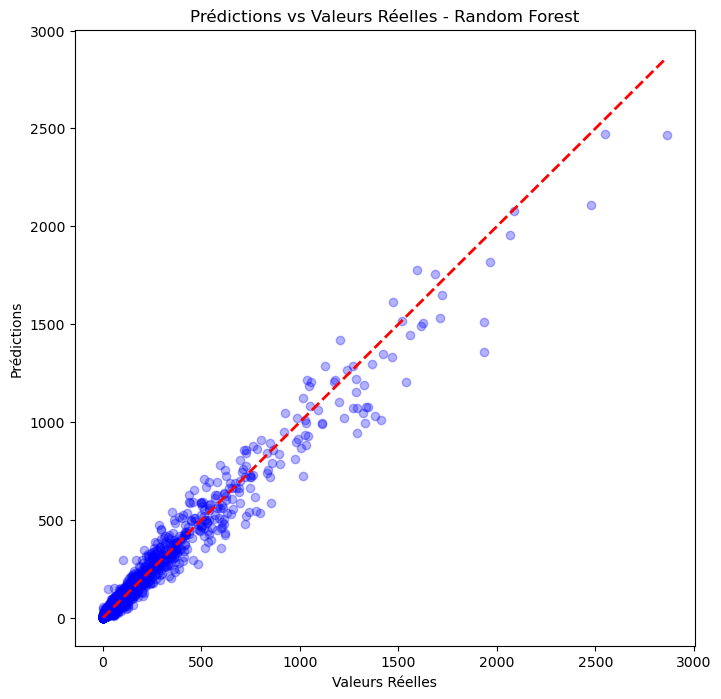

In [74]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test2, y_pred_grid2, alpha=0.3, color="blue")
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'r--', lw=2)
plt.xlabel("Valeurs Réelles")
plt.ylabel("Prédictions")
plt.title("Prédictions vs Valeurs Réelles - Random Forest")
plt.show()

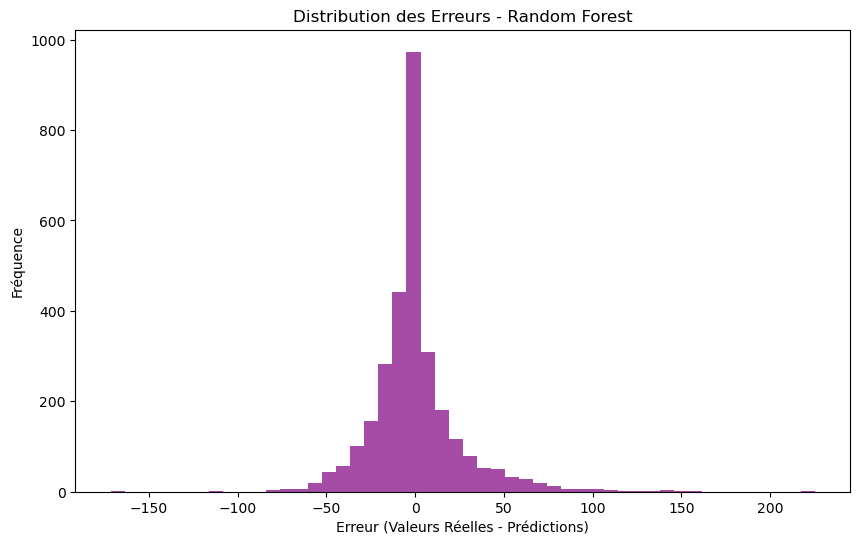

In [75]:
errors = y_test - y_pred_grid
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, color="purple", alpha=0.7)
plt.xlabel("Erreur (Valeurs Réelles - Prédictions)")
plt.ylabel("Fréquence")
plt.title("Distribution des Erreurs - Random Forest")
plt.show()

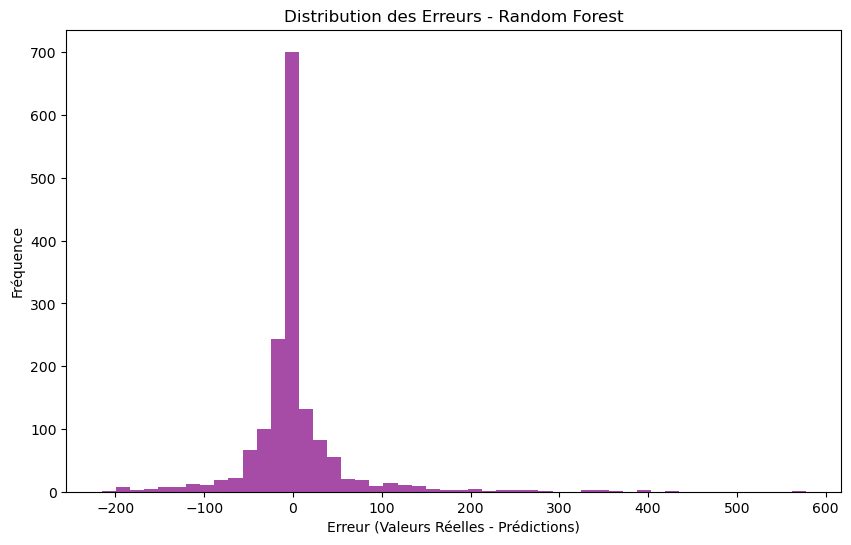

In [76]:
errors2 = y_test2 - y_pred_grid2
plt.figure(figsize=(10, 6))
plt.hist(errors2, bins=50, color="purple", alpha=0.7)
plt.xlabel("Erreur (Valeurs Réelles - Prédictions)")
plt.ylabel("Fréquence")
plt.title("Distribution des Erreurs - Random Forest")
plt.show()

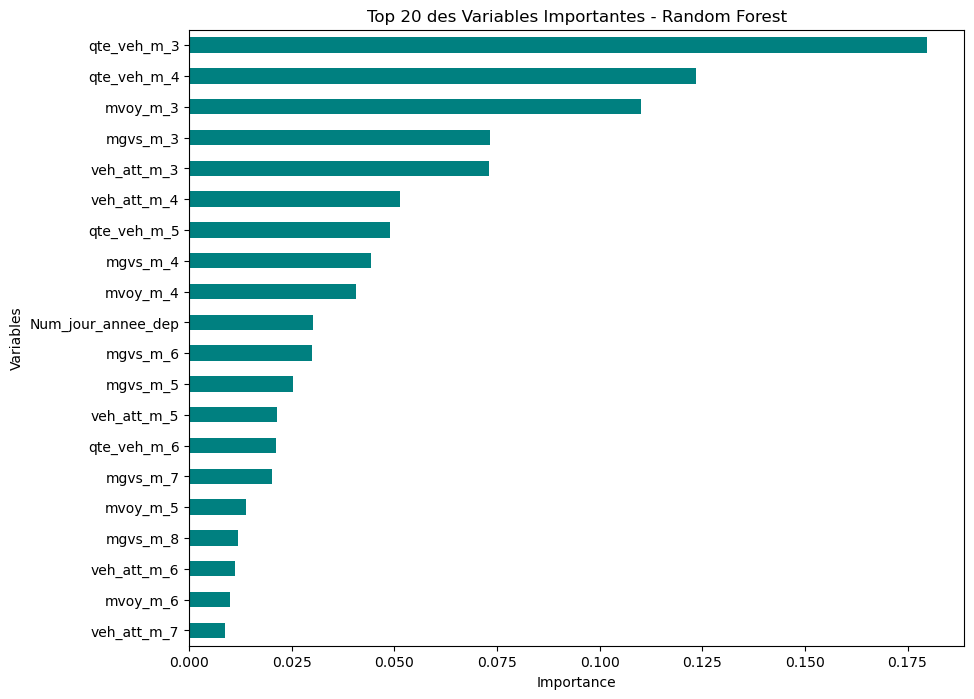

In [77]:
# Extraire et trier les importances
importances = model_grid.feature_importances_
features = X.columns
feature_importances = pd.Series(importances, index=features)
feature_importances = feature_importances.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - Random Forest")
plt.gca().invert_yaxis() # Pour que la variable la plus importante soit en haut
plt.show()

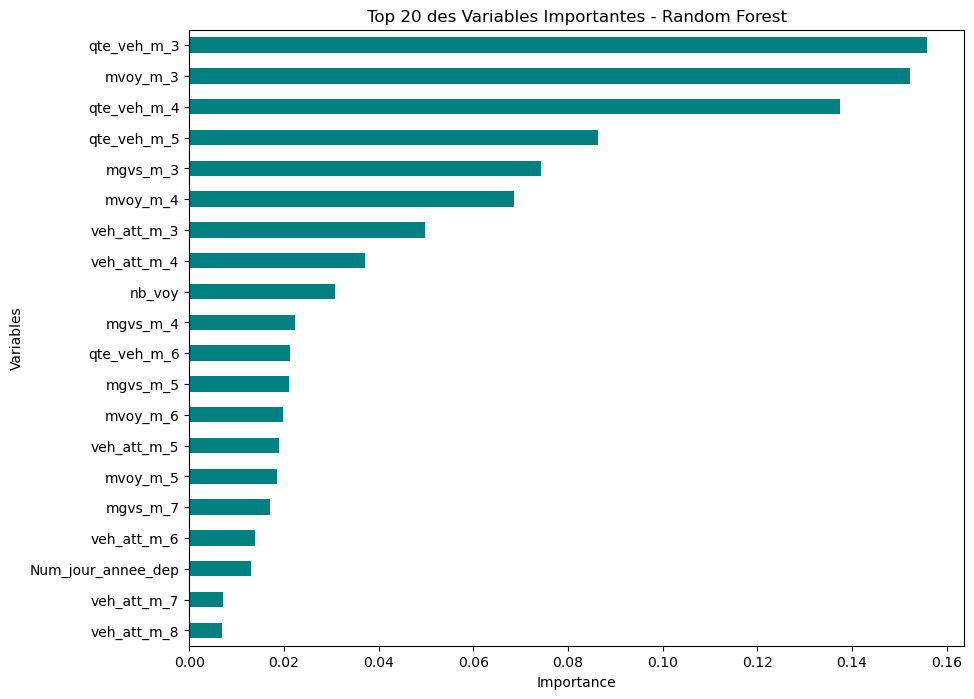

In [78]:
# Extraire et trier les importances
importances2 = model_grid2.feature_importances_
features2 = X2.columns
feature_importances2 = pd.Series(importances2, index=features2)
feature_importances2 = feature_importances2.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances2.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - Random Forest")
plt.gca().invert_yaxis() # Pour que la variable la plus importante soit en haut
plt.show()

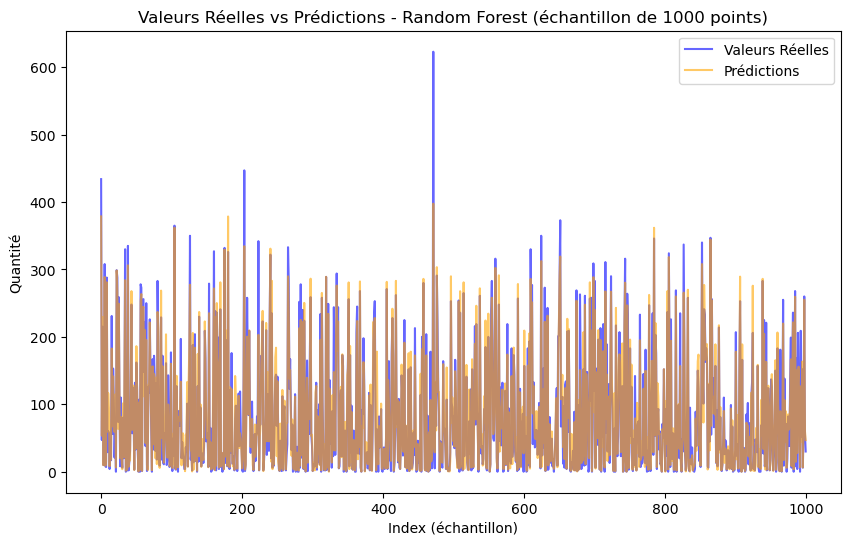

In [79]:
# Prendre un sous-échantillon de 500 points
sample_size = 1000
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)

y_test_sample = y_test.iloc[sample_indices]
y_pred_sample = y_pred_grid[sample_indices]

# Tracer les valeurs réelles vs les prédictions pour le sous-échantillon
plt.figure(figsize=(10, 6))
plt.plot(y_test_sample.values, label='Valeurs Réelles', color='blue', alpha=0.6)
plt.plot(y_pred_sample, label='Prédictions', color='orange', alpha=0.6)
plt.xlabel("Index (échantillon)")
plt.ylabel("Quantité")
plt.title("Valeurs Réelles vs Prédictions - Random Forest (échantillon de 1000 points)")
plt.legend()
plt.show()

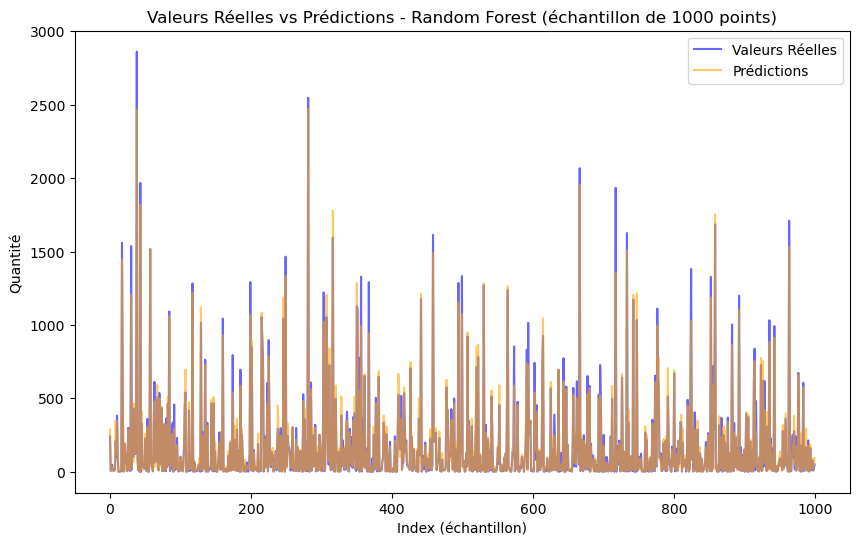

In [80]:
# Prendre un sous-échantillon de 500 points
sample_size = 1000
sample_indices2 = np.random.choice(len(y_test2), sample_size, replace=False)

y_test_sample2 = y_test2.iloc[sample_indices2]
y_pred_sample2 = y_pred_grid2[sample_indices2]

# Tracer les valeurs réelles vs les prédictions pour le sous-échantillon
plt.figure(figsize=(10, 6))
plt.plot(y_test_sample2.values, label='Valeurs Réelles', color='blue', alpha=0.6)
plt.plot(y_pred_sample2, label='Prédictions', color='orange', alpha=0.6)
plt.xlabel("Index (échantillon)")
plt.ylabel("Quantité")
plt.title("Valeurs Réelles vs Prédictions - Random Forest (échantillon de 1000 points)")
plt.legend()
plt.show()

### Version avec validation croisée temporelle ###

In [97]:
from sklearn.model_selection import TimeSeriesSplit # type: ignore
from sklearn.ensemble import RandomForestRegressor # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore

# Nombre de splits pour la validation croisée
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Sauvegarder les scores pour chaque split
mae_scores = []
rmse_scores = []
r2_scores = []
mape_scores = []
mape_filtered_scores = []

# Ajouter toutes les erreurs absolues à chaque étape de validation croisée
all_results = []

for train_index, test_index in tscv.split(X):
    X_train_cross, X_test_cross = X.iloc[train_index], X.iloc[test_index]
    y_train_cross, y_test_cross = y.iloc[train_index], y.iloc[test_index]
    
    # Initialiser et entraîner le modèle
    model_cross_val = RandomForestRegressor(n_estimators=100, random_state=42, verbose=1)
    model_cross_val.fit(X_train_cross, y_train_cross)
    
    # Prédictions
    y_pred_cross_val = model_cross_val.predict(X_test_cross)
    
    # Calcul des métriques d'erreur
    mae_cross_val = mean_absolute_error(y_test_cross, y_pred_cross_val)
    rmse_cross_val = np.sqrt(mean_squared_error(y_test_cross, y_pred_cross_val))
    r2_cross_val = r2_score(y_test_cross, y_pred_cross_val)
    mape_cross_val = np.mean(np.abs((y_test_cross - y_pred_cross_val) / y_test_cross)) * 100
    
    # Enregistrer les scores
    mae_scores.append(mae_cross_val)
    rmse_scores.append(rmse_cross_val)
    r2_scores.append(r2_cross_val)
    mape_scores.append(mape_cross_val)

    # Filtrer les valeurs positives de y_test_cross et recalculer le MAPE
    y_test_filtered = y_test_cross[y_test_cross > 0]
    y_pred_filtered = y_pred_cross_val[y_test_cross > 0]
    mape_filtered = np.mean(np.abs((y_test_filtered - y_pred_filtered) / y_test_filtered)) * 100
    mape_filtered_scores.append(mape_filtered)

    # Calculer l'erreur absolue pour ce split
    df_split_results = X_test_cross.copy()
    df_split_results['y_test'] = y_test_cross
    df_split_results['y_pred'] = y_pred_cross_val
    df_split_results['err-abs'] = abs(y_test_cross - y_pred_cross_val)
    all_results.append(df_split_results)

# Afficher les résultats moyens
print(f"MAE moyen sur les {n_splits} splits: {np.mean(mae_scores):.2f}")
print(f"RMSE moyen sur les {n_splits} splits: {np.mean(rmse_scores):.2f}")
print(f"R² moyen : {np.mean(r2_scores):.4f}")
print(f"MAPE moyen : {np.mean(mape_scores):.2f}%")
print(f"MAPE moyen (valeurs positives uniquement) : {np.mean(mape_filtered_scores):.2f}%")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.4s


MAE moyen sur les 5 splits: 31.87
RMSE moyen sur les 5 splits: 40.00
R² moyen : 0.5830
MAPE moyen : inf%
MAPE moyen (valeurs positives uniquement) : 732.27%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [98]:
# Concaténer les résultats de chaque split
df_cross_val_results = pd.concat(all_results)
# Trié Dataframe par erreur absolue
df_cross_val_results = df_cross_val_results.sort_values(by='err-abs', ascending=False)
df_cross_val_results.head(20)

,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err-abs
7074,192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,208.63,208.63
7108,192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,208.63,207.63
7086,192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,208.63,207.63
7003,191,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,208.54,207.54
10886,242,35.0,8.0,2.0,1.0,0.0,0.0,26.0,5.0,1.0,1.0,0.0,0.0,8.0,14.0,5.0,6.0,7.0,0.0,140.0,118.0,52.0,24.0,49.0,6.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,327.0,120.69,206.31
7059,191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,208.63,205.63
7130,192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,7.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,207.09,205.09
6996,191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,203.67,201.67
6758,188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,194.91,194.91
6770,188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,194.91,194.91


In [ ]:
# Exportation des résultats dans un fichier Excel
df_cross_val_results.to_excel("df_results_cross_validation.xlsx", index=False)

In [90]:
from sklearn.model_selection import TimeSeriesSplit # type: ignore
from sklearn.ensemble import RandomForestRegressor # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore

# Nombre de splits pour la validation croisée
n_splits = 5
tscv2 = TimeSeriesSplit(n_splits=n_splits)

# Sauvegarder les scores pour chaque split
mae_scores2 = []
rmse_scores2 = []
r2_scores2 = []
mape_scores2 = []
mape_filtered_scores2 = []

# Ajouter toutes les erreurs absolues à chaque étape de validation croisée
all_results2 = []

for train_index2, test_index2 in tscv2.split(X2):
    X_train_cross2, X_test_cross2 = X2.iloc[train_index2], X2.iloc[test_index2]
    y_train_cross2, y_test_cross2 = y2.iloc[train_index2], y2.iloc[test_index2]
    
    # Initialiser et entraîner le modèle
    model_cross_val2 = RandomForestRegressor(n_estimators=100, random_state=42, verbose=1)
    model_cross_val2.fit(X_train_cross2, y_train_cross2)
    
    # Prédictions
    y_pred_cross_val2 = model_cross_val2.predict(X_test_cross2)
    
    # Calcul des métriques d'erreur
    mae_cross_val2 = mean_absolute_error(y_test_cross2, y_pred_cross_val2)
    rmse_cross_val2 = np.sqrt(mean_squared_error(y_test_cross2, y_pred_cross_val2))
    r2_cross_val2 = r2_score(y_test_cross2, y_pred_cross_val2)
    mape_cross_val2 = np.mean(np.abs((y_test_cross2 - y_pred_cross_val2) / y_test_cross2)) * 100
    
    # Enregistrer les scores
    mae_scores2.append(mae_cross_val2)
    rmse_scores2.append(rmse_cross_val2)
    r2_scores2.append(r2_cross_val2)
    mape_scores2.append(mape_cross_val2)

    # Filtrer les valeurs positives de y_test et recalculer le MAPE
    y_test_filtered2 = y_test_cross2[y_test_cross2 > 0]
    y_pred_filtered2 = y_pred_cross_val2[y_test_cross2 > 0]
    mape_filtered2 = np.mean(np.abs((y_test_filtered2 - y_pred_filtered2) / y_test_filtered2)) * 100
    mape_filtered_scores2.append(mape_filtered2)

    # Calculer l'erreur absolue pour ce split
    df_split_results2 = X_test_cross2.copy()
    df_split_results2['y_test'] = y_test_cross2
    df_split_results2['y_pred'] = y_pred_cross_val2
    df_split_results2['err-abs'] = abs(y_test_cross2 - y_pred_cross_val2)
    all_results2.append(df_split_results2)

# Afficher les résultats moyens
print(f"MAE moyen sur les {n_splits} splits: {np.mean(mae_scores2):.2f}")
print(f"RMSE moyen sur les {n_splits} splits: {np.mean(rmse_scores2):.2f}")
print(f"R² moyen : {np.mean(r2_scores2):.4f}")
print(f"MAPE moyen : {np.mean(mape_scores2):.2f}%")
print(f"MAPE moyen (valeurs positives uniquement) : {np.mean(mape_filtered_scores2):.2f}%")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s


MAE moyen sur les 5 splits: 24.81
RMSE moyen sur les 5 splits: 37.82
R² moyen : 0.9119
MAPE moyen : inf%
MAPE moyen (valeurs positives uniquement) : 81.36%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [91]:
# Concaténer les résultats de chaque split
df_cross_val_results2 = pd.concat(all_results2)
# Trié Dataframe par erreur absolue
df_cross_val_results2 = df_cross_val_results2.sort_values(by='err-abs', ascending=False)
df_cross_val_results2.head(20)

,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err-abs
2852,155,165.0,110.0,60.0,15.0,0.0,0.0,95.000000,79.000000,78.0,79.0,79.0,79.0,1.0,10.0,0.0,0.0,0.0,0.0,11.0,33.0,25.0,29.0,8.0,4.0,2,0,0,0,0,0,1,0,294.0,688.00,394.00
1987,120,145.0,21.0,13.0,10.0,8.0,1.0,43.000000,21.000000,13.0,10.0,8.0,1.0,20.0,9.0,4.0,6.0,2.0,12.0,90.0,39.0,23.0,28.0,6.0,86.0,3,0,0,0,0,0,0,1,289.0,587.89,298.89
4811,219,92.0,30.0,11.0,6.0,0.0,0.0,67.000000,25.000000,11.0,6.0,6.0,6.0,54.0,45.0,11.0,5.0,5.0,0.0,326.0,334.0,44.0,52.0,58.0,24.0,3,0,0,0,0,0,1,0,732.0,451.98,280.02
2320,134,78.0,79.0,76.0,64.0,23.0,4.0,77.000000,77.000000,77.0,77.0,77.0,77.0,0.0,4.0,0.0,0.0,1.0,0.0,18.0,18.0,13.0,64.0,17.0,11.0,2,1,0,0,0,0,0,1,101.0,356.40,255.40
4584,212,132.0,41.0,14.0,10.0,0.0,0.0,132.000000,41.000000,14.0,13.0,12.0,12.0,36.0,15.0,1.0,1.0,0.0,0.0,838.0,817.0,161.0,163.0,105.0,47.0,4,1,0,0,0,0,0,0,776.0,525.51,250.49
3492,177,122.0,82.0,33.0,9.0,3.0,0.0,121.000000,81.000000,56.0,56.0,58.0,58.0,19.0,26.0,3.0,2.0,5.0,0.0,58.0,74.0,15.0,10.0,23.0,12.0,5,0,0,0,0,0,0,1,853.0,604.98,248.02
5717,248,206.0,128.0,65.0,33.0,15.0,0.0,184.000000,112.000000,54.0,31.0,19.0,19.0,30.0,39.0,21.0,2.0,14.0,0.0,94.0,101.0,46.0,9.0,22.0,31.0,3,0,0,0,0,0,1,1,509.0,752.64,243.64
3283,170,49.0,27.0,15.0,8.0,1.0,0.0,48.000000,26.000000,21.0,21.0,21.0,22.0,8.0,12.0,1.0,2.0,1.0,0.0,128.0,62.0,26.0,41.0,33.0,16.0,3,0,0,0,0,0,0,0,517.0,274.37,242.63
4911,222,111.0,53.0,26.0,13.0,1.0,0.0,111.000000,53.000000,26.0,13.0,1.0,0.0,46.0,14.0,4.0,9.0,2.0,0.0,575.0,318.0,65.0,117.0,29.0,0.0,3,1,0,0,0,0,0,1,303.0,526.57,223.57
5871,253,365.0,212.0,92.0,50.0,27.0,6.0,361.000000,209.000000,90.0,48.0,25.0,25.0,30.0,31.0,30.0,8.0,9.0,3.0,132.0,163.0,125.0,31.0,41.0,46.0,5,0,0,0,0,0,0,0,802.0,1015.54,213.54


In [ ]:
# Exportation des résultats dans un fichier Excel
df_cross_val_results2.to_excel("df_results_cross_validation2.xlsx", index=False)

### Visualisation avec validation croisée temporelle ###

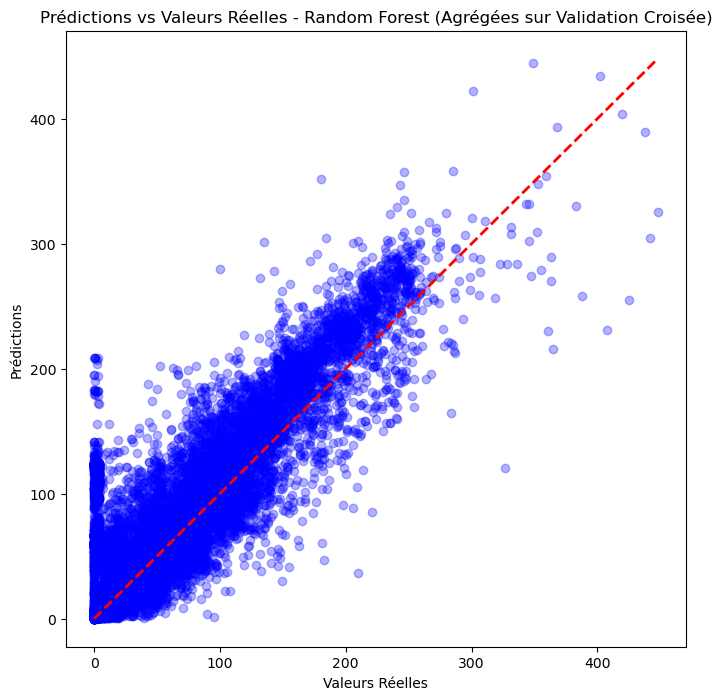

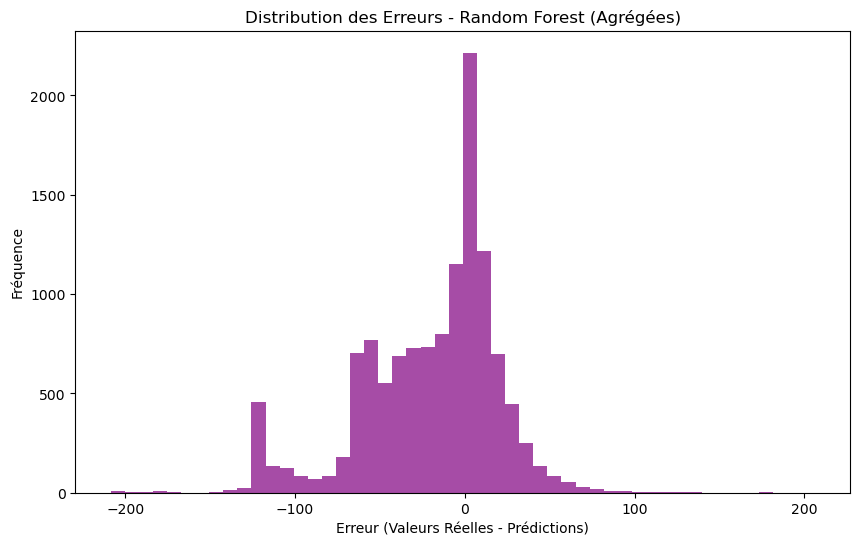

In [99]:
# Visualisation des Prédictions vs Valeurs Réelles agrégées
plt.figure(figsize=(8, 8))
plt.scatter(df_cross_val_results['y_test'], df_cross_val_results['y_pred'], alpha=0.3, color="blue")
plt.plot([df_cross_val_results['y_test'].min(), df_cross_val_results['y_test'].max()], [df_cross_val_results['y_test'].min(), df_cross_val_results['y_test'].max()], 'r--', lw=2)
plt.xlabel("Valeurs Réelles")
plt.ylabel("Prédictions")
plt.title("Prédictions vs Valeurs Réelles - Random Forest (Agrégées sur Validation Croisée)")
plt.show()

# Distribution des Erreurs Agrégées
errors = df_cross_val_results['y_test'] - df_cross_val_results['y_pred']
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, color="purple", alpha=0.7)
plt.xlabel("Erreur (Valeurs Réelles - Prédictions)")
plt.ylabel("Fréquence")
plt.title("Distribution des Erreurs - Random Forest (Agrégées)")
plt.show()

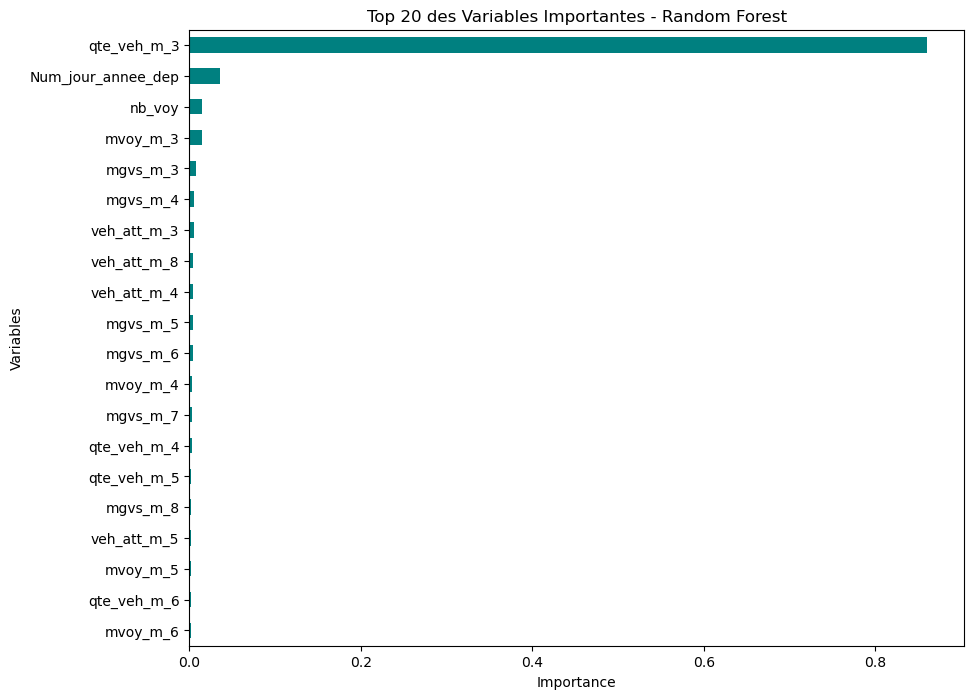

In [86]:
importances = model_cross_val.feature_importances_
features = X.columns
feature_importances = pd.Series(importances, index=features)
feature_importances = feature_importances.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - Random Forest")
plt.gca().invert_yaxis()  # Pour que la variable la plus importante soit en haut
plt.show()

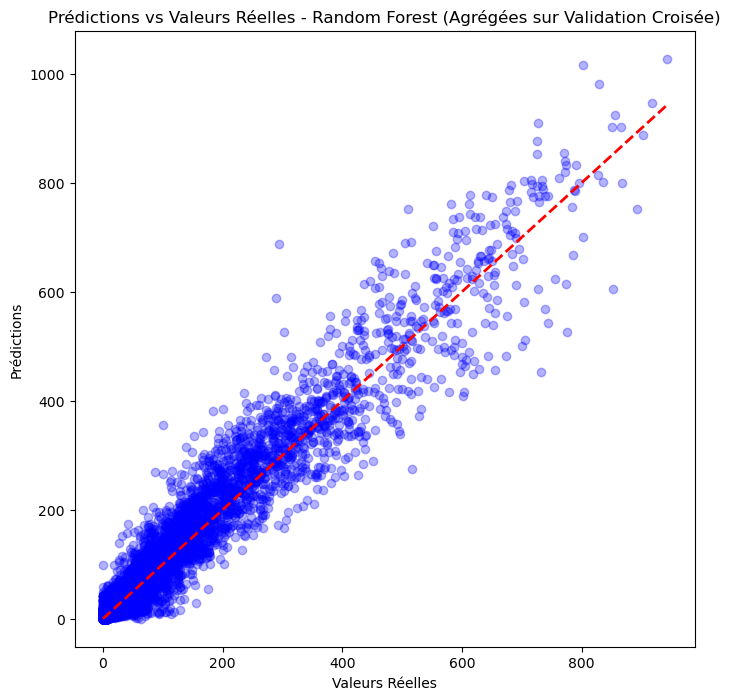

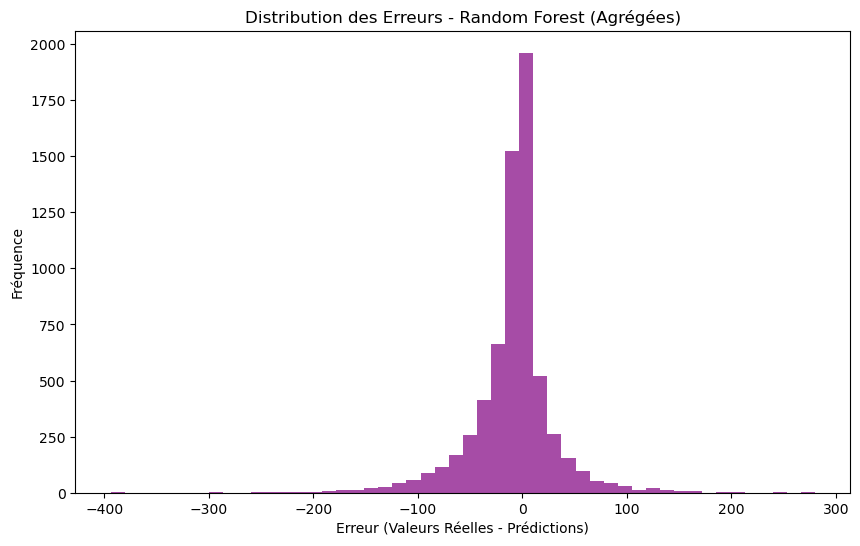

In [92]:
# Visualisation des Prédictions vs Valeurs Réelles agrégées
plt.figure(figsize=(8, 8))
plt.scatter(df_cross_val_results2['y_test'], df_cross_val_results2['y_pred'], alpha=0.3, color="blue")
plt.plot([df_cross_val_results2['y_test'].min(), df_cross_val_results2['y_test'].max()], [df_cross_val_results2['y_test'].min(), df_cross_val_results2['y_test'].max()], 'r--', lw=2)
plt.xlabel("Valeurs Réelles")
plt.ylabel("Prédictions")
plt.title("Prédictions vs Valeurs Réelles - Random Forest (Agrégées sur Validation Croisée)")
plt.show()

# Distribution des Erreurs Agrégées
errors2 = df_cross_val_results2['y_test'] - df_cross_val_results2['y_pred']
plt.figure(figsize=(10, 6))
plt.hist(errors2, bins=50, color="purple", alpha=0.7)
plt.xlabel("Erreur (Valeurs Réelles - Prédictions)")
plt.ylabel("Fréquence")
plt.title("Distribution des Erreurs - Random Forest (Agrégées)")
plt.show()

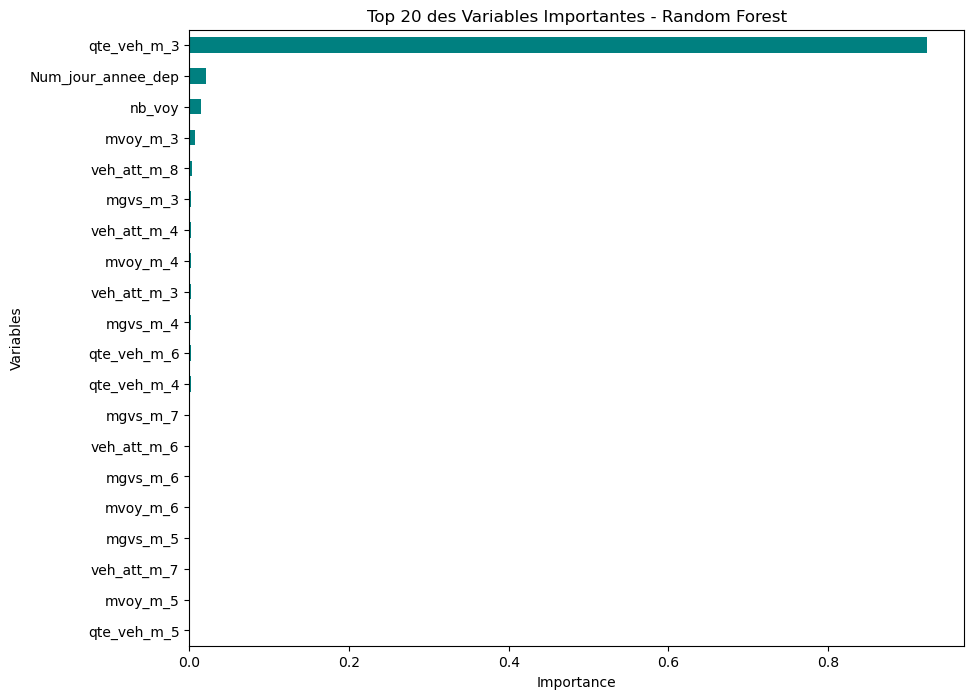

In [88]:
importances2 = model_cross_val2.feature_importances_
features2 = X2.columns
feature_importances2 = pd.Series(importances2, index=features2)
feature_importances2 = feature_importances2.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances2.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - Random Forest")
plt.gca().invert_yaxis()  # Pour que la variable la plus importante soit en haut
plt.show()

### Essais autres modèles: LightGBM, XGBoost ###

#### LightGBM ####

In [100]:
X.columns = X.columns.str.replace(' ', '_')
X2.columns = X2.columns.str.replace(' ', '_')

In [101]:
# LightGBM 
from sklearn.model_selection import train_test_split # type: ignore
from lightgbm import LGBMRegressor # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore

# Séparer les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# Initialiser le modèle LightGBM avec des hyperparamètres de base
lgb_model = LGBMRegressor(n_estimators=100, random_state=42, verbose=1) 

# LGBMRegressor(force_col_wise=True)

# Entraîner le modèle sur les données d'entraînement
lgb_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_lgb = lgb_model.predict(X_test)

# Évaluer le modèle
score_lgb  = lgb_model.score(X_test, y_test)
print("Score de LightGBM :", score_lgb)

# Évaluer les performances du modèle
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f"LightGBM - Mean Absolute Error (MAE) : {mae_lgb}")
print(f"LightGBM - Root Mean Squared Error (RMSE) : {rmse_lgb}")
print(f"LightGBM - Coefficient de détermination (R²) : {r2_lgb}")

# Facultatif : Ajouter les prédictions et les erreurs à un DataFrame pour analyse
df_results_lightgbm = X_test.copy()
df_results_lightgbm['y_test'] = y_test
df_results_lightgbm['y_pred'] = y_pred_lgb
df_results_lightgbm['err-abs'] = abs(df_results_lightgbm['y_test'] - df_results_lightgbm['y_pred'])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3346
[LightGBM] [Info] Number of data points in the train set: 12020, number of used features: 72
[LightGBM] [Info] Start training from score 85.058236
Score de LightGBM : 0.9437863082083718
LightGBM - Mean Absolute Error (MAE) : 14.471938851307852
LightGBM - Root Mean Squared Error (RMSE) : 22.012358302562674
LightGBM - Coefficient de détermination (R²) : 0.9437863082083718


In [102]:
# Afficher le dataframe dans l'ordre décroissant par rapport à l'erreur
df_results_lightgbm = df_results_lightgbm.sort_values(by='err-abs', ascending=False)
df_results_lightgbm.head(20)

,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err-abs
9593,225,159.0,94.0,53.0,24.0,8.0,0.0,159.000000,94.0,53.0,24.0,22.0,22.0,10.0,29.0,3.0,6.0,5.0,0.0,980.0,828.0,164.0,212.0,163.0,88.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,180.0,353.748520,173.748520
9510,224,77.0,23.0,9.0,3.0,1.0,0.0,59.000000,15.0,7.0,3.0,3.0,3.0,44.0,17.0,8.0,7.0,5.0,0.0,301.0,134.0,24.0,95.0,52.0,16.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,286.0,428.470147,142.470147
9121,219,6.0,3.0,0.0,0.0,0.0,0.0,3.000000,2.0,0.0,0.0,0.0,0.0,3.0,2.0,2.0,0.0,0.0,0.0,326.0,334.0,44.0,52.0,58.0,24.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,183.0,49.887372,133.112628
9670,226,215.0,94.0,42.0,20.0,5.0,0.0,215.000000,94.0,42.0,20.0,19.0,19.0,52.0,42.0,4.0,3.0,11.0,0.0,789.0,779.0,91.0,100.0,116.0,30.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,623.0,502.730652,120.269348
7231,194,4.0,0.0,0.0,0.0,0.0,0.0,4.000000,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,186.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,221.0,102.050501,118.949499
4537,151,14.0,0.0,0.0,0.0,0.0,0.0,14.000000,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,49.0,60.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184.0,71.669529,112.330471
5892,174,1.0,1.0,0.0,0.0,0.0,0.0,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,11.0,7.0,0.0,0.0,0.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,155.0,43.682159,111.317841
6330,181,9.0,1.0,0.0,0.0,0.0,0.0,8.000000,2.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,2.0,0.0,0.0,235.0,108.0,115.0,77.0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213.0,108.727936,104.272064
9060,218,84.0,40.0,21.0,12.0,5.0,0.0,71.000000,35.0,19.0,14.0,14.0,14.0,31.0,8.0,6.0,2.0,3.0,0.0,135.0,81.0,17.0,20.0,15.0,8.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,268.0,366.633896,98.633896
7860,202,42.0,8.0,2.0,0.0,0.0,0.0,146.000000,8.0,2.0,0.0,0.0

In [103]:
# Export excel
df_results_lightgbm.to_excel("df_results_lightgbm.xlsx", index=False)

In [104]:
from sklearn.model_selection import cross_val_score # type: ignore

scores_lgb = cross_val_score(lgb_model, X, y, cv=5, scoring='r2')
print("Scores R² pour chaque fold :", scores_lgb)
print("Score moyen R² :", scores_lgb.mean())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2852
[LightGBM] [Info] Number of data points in the train set: 12020, number of used features: 73
[LightGBM] [Info] Start training from score 60.241265
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3408
[LightGBM] [Info] Number of data points in the train set: 12020, number of used features: 69
[LightGBM] [Info] Start training from score 102.382612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3405
[LightGBM] [Info] Number of data points in the train set: 12020, number of used features: 74
[LightGBM] [Info] Start 

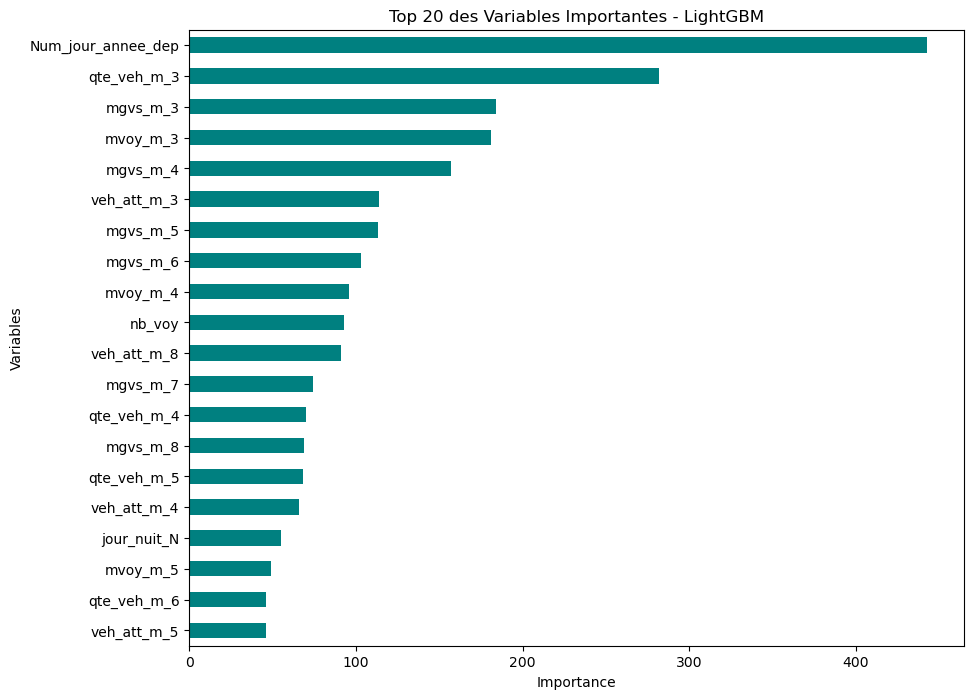

In [105]:
# Extraire et trier les importances des caractéristiques

importances_lgb = lgb_model.feature_importances_  # Méthode spécifique pour LightGBM
features_lgb = X.columns
feature_importances_lgb = pd.Series(importances_lgb, index=features_lgb)
feature_importances_lgb = feature_importances_lgb.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_lgb.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - LightGBM")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

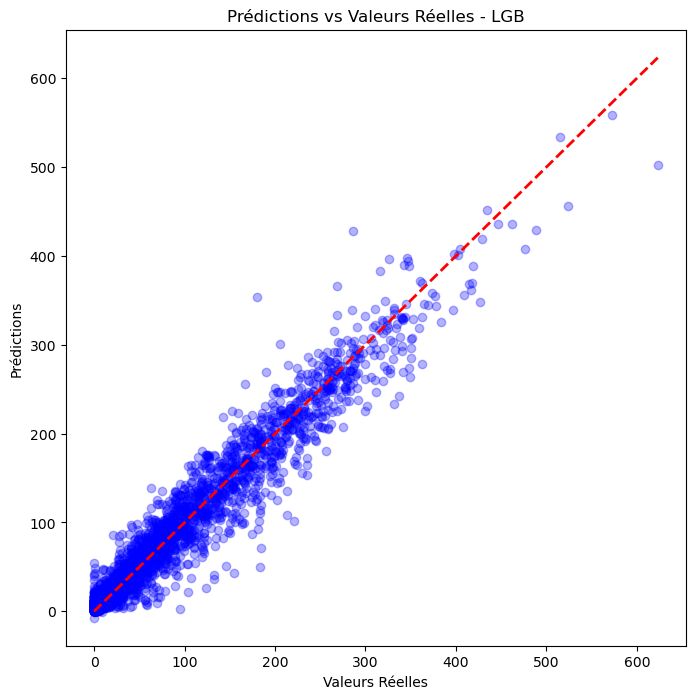

In [107]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_lgb, alpha=0.3, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valeurs Réelles")
plt.ylabel("Prédictions")
plt.title("Prédictions vs Valeurs Réelles - LGB")
plt.show()

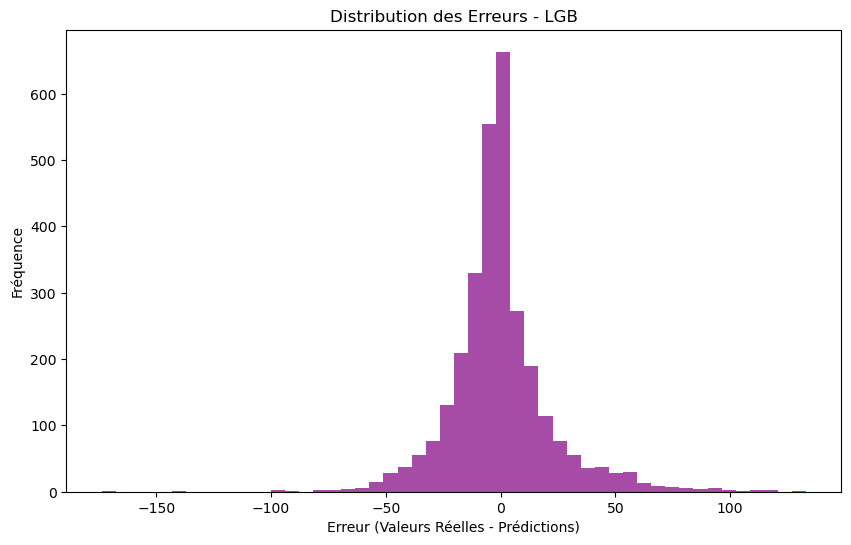

In [108]:
errors_lgb = y_test - y_pred_lgb
plt.figure(figsize=(10, 6))
plt.hist(errors_lgb, bins=50, color="purple", alpha=0.7)
plt.xlabel("Erreur (Valeurs Réelles - Prédictions)")
plt.ylabel("Fréquence")
plt.title("Distribution des Erreurs - LGB")
plt.show()

In [109]:
# LightGBM 
from sklearn.model_selection import train_test_split # type: ignore
from lightgbm import LGBMRegressor # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore

# Séparer les données
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42) 

# Initialiser le modèle LightGBM avec des hyperparamètres de base
lgb_model2 = LGBMRegressor(n_estimators=100, random_state=42, verbose=1) 

# LGBMRegressor(force_col_wise=True)

# Entraîner le modèle sur les données d'entraînement
lgb_model2.fit(X_train2, y_train2)

# Faire des prédictions sur l'ensemble de test
y_pred_lgb2 = lgb_model2.predict(X_test2)

# Évaluer le modèle
score_lgb2  = lgb_model2.score(X_test2, y_test2)
print("Score de LightGBM :", score_lgb2)

# Évaluer les performances du modèle
mae_lgb2 = mean_absolute_error(y_test2, y_pred_lgb2)
rmse_lgb2 = np.sqrt(mean_squared_error(y_test2, y_pred_lgb2))
r2_lgb2 = r2_score(y_test2, y_pred_lgb2)

print(f"LightGBM - Mean Absolute Error (MAE) : {mae_lgb2}")
print(f"LightGBM - Root Mean Squared Error (RMSE) : {rmse_lgb2}")
print(f"LightGBM - Coefficient de détermination (R²) : {r2_lgb2}")

# Facultatif : Ajouter les prédictions et les erreurs à un DataFrame pour analyse
df_results_lightgbm2 = X_test2.copy()
df_results_lightgbm2['y_test'] = y_test2
df_results_lightgbm2['y_pred'] = y_pred_lgb2
df_results_lightgbm2['err-abs'] = abs(df_results_lightgbm2['y_test'] - df_results_lightgbm2['y_pred'])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3600
[LightGBM] [Info] Number of data points in the train set: 6337, number of used features: 33
[LightGBM] [Info] Start training from score 157.436958
Score de LightGBM : 0.9779058229123347
LightGBM - Mean Absolute Error (MAE) : 24.00426433119375
LightGBM - Root Mean Squared Error (RMSE) : 46.007619226022186
LightGBM - Coefficient de détermination (R²) : 0.9779058229123347


In [110]:
# Afficher le dataframe dans l'ordre décroissant par rapport à l'erreur
df_results_lightgbm2 = df_results_lightgbm2.sort_values(by='err-abs', ascending=False)
df_results_lightgbm2.head(20)

,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles_Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err-abs
4995,225,1648.0,1006.0,536.0,277.0,73.0,0.0,1643.000000,897.000000,487.000000,248.0,225.0,225.0,200.0,203.0,54.0,77.0,52.0,0.0,980.0,828.0,164.0,212.0,163.0,88.0,9,0,0,0,0,0,0,1,2861.0,2365.532427,495.467573
2852,155,165.0,110.0,60.0,15.0,0.0,0.0,95.000000,79.000000,78.000000,79.0,79.0,79.0,1.0,10.0,0.0,0.0,0.0,0.0,11.0,33.0,25.0,29.0,8.0,4.0,2,0,0,0,0,0,1,0,294.0,639.211536,345.211536
5247,233,823.0,472.0,219.0,117.0,32.0,0.0,823.000000,352.000000,176.000000,93.0,60.0,60.0,115.0,140.0,17.0,23.0,15.0,0.0,700.0,957.0,93.0,141.0,88.0,118.0,5,0,0,0,0,0,0,1,1595.0,1935.448006,340.448006
4774,218,1256.0,691.0,392.0,177.0,39.0,0.0,1091.000000,606.000000,346.000000,185.0,185.0,185.0,169.0,201.0,42.0,49.0,33.0,0.0,655.0,677.0,120.0,175.0,95.0,77.0,8,0,0,0,0,0,0,1,2478.0,2175.022269,302.977731
5394,237,1549.0,1215.0,635.0,345.0,74.0,11.0,3208.428571,4243.571429,635.000000,345.0,74.0,11.0,193.0,169.0,187.0,189.0,113.0,29.0,1187.0,874.0,564.0,616.0,326.0,125.0,8,0,0,0,0,0,0,1,2547.0,2289.605079,257.394921
5510,242,495.0,254.0,87.0,43.0,17.0,0.0,490.000000,165.000000,58.000000,35.0,19.0,19.0,108.0,56.0,20.0,2.0,20.0,0.0,341.0,335.0,113.0,42.0,93.0,46.0,5,0,0,0,0,0,0,1,1537.0,1280.567574,256.432426
3460,176,228.0,138.0,60.0,22.0,5.0,0.0,224.000000,136.000000,102.000000,102.0,102.0,104.0,41.0,52.0,20.0,21.0,32.0,0.0,178.0,152.0,72.0,87.0,92.0,37.0,6,0,0,0,0,0,0,0,1333.0,1079.862279,253.137721
5338,236,653.0,284.0,96.0,53.0,11.0,1.0,665.000000,284.000000,96.000000,53.0,27.0,27.0,79.0,76.0,37.0,27.0,11.0,0.0,470.0,417.0,183.0,199.0,71.0,118.0,7,0,0,0,0,0,0,1,1934.0,1680.923519,253.076481
4711,216,255.0,86.0,44.0,18.0,5.0,0.0,170.000000,55.000000,27.000000,14.0,14.0,14.0,38.0,29.0,5.0,15.0,3.0,0.0,357.0,126.0,56.0,62.0,20.0,32.0,4,0,0,0,0,0,0,1,1014.0,778.196220,235.803780
5412,238,262.0,134.0,46.0,22.0,5.0,0.0,262.000000,134.000000,46.000000,22.0,5.0,0.0,72.0,63.0,27.0,5.0,26.0,0.0,381.0,401.0,217.0,101.0,112.0,0.0,7,0,0,0,0,0,0,0,715.0,945.709574,230.709574


In [111]:
# Export excel
df_results_lightgbm2.to_excel("df_results_lightgbm2.xlsx", index=False)

In [112]:
from sklearn.model_selection import cross_val_score # type: ignore

scores_lgb2 = cross_val_score(lgb_model2, X, y, cv=5, scoring='r2')
print("Scores R² pour chaque fold :", scores_lgb2)
print("Score moyen R² :", scores_lgb2.mean())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2852
[LightGBM] [Info] Number of data points in the train set: 12020, number of used features: 73
[LightGBM] [Info] Start training from score 60.241265
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3408
[LightGBM] [Info] Number of data points in the train set: 12020, number of used features: 69
[LightGBM] [Info] Start training from score 102.382612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3405
[LightGBM] [Info] Number of data points in the train set: 12020, number of used features: 74
[LightGBM] [Info] Start 

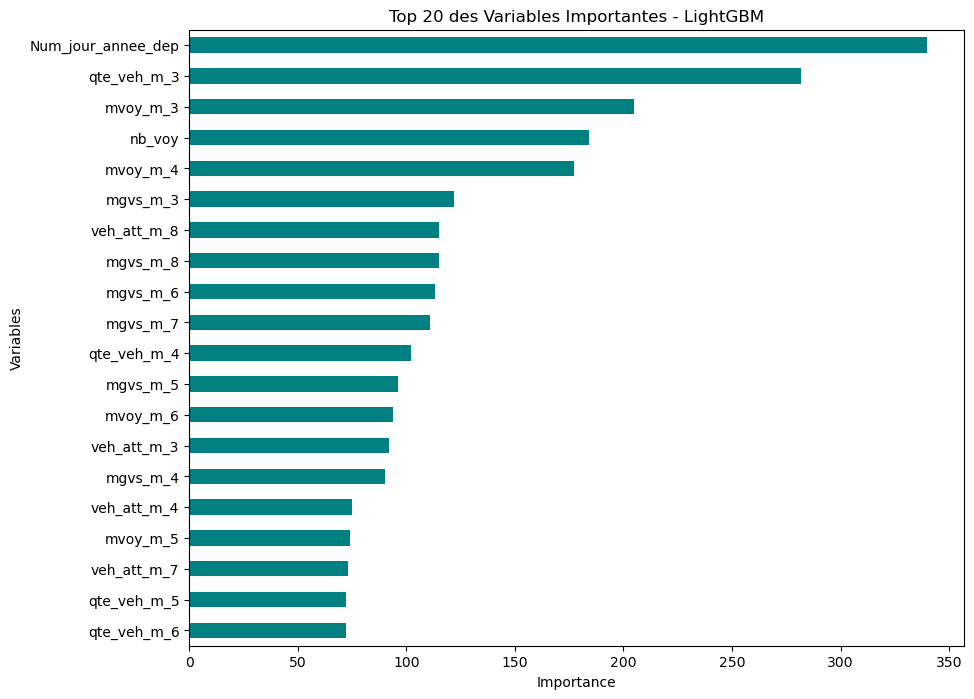

In [113]:
# Extraire et trier les importances des caractéristiques

importances_lgb2 = lgb_model2.feature_importances_  # Méthode spécifique pour LightGBM
features_lgb2 = X2.columns
feature_importances_lgb2 = pd.Series(importances_lgb2, index=features_lgb2)
feature_importances_lgb2 = feature_importances_lgb2.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_lgb2.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - LightGBM")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

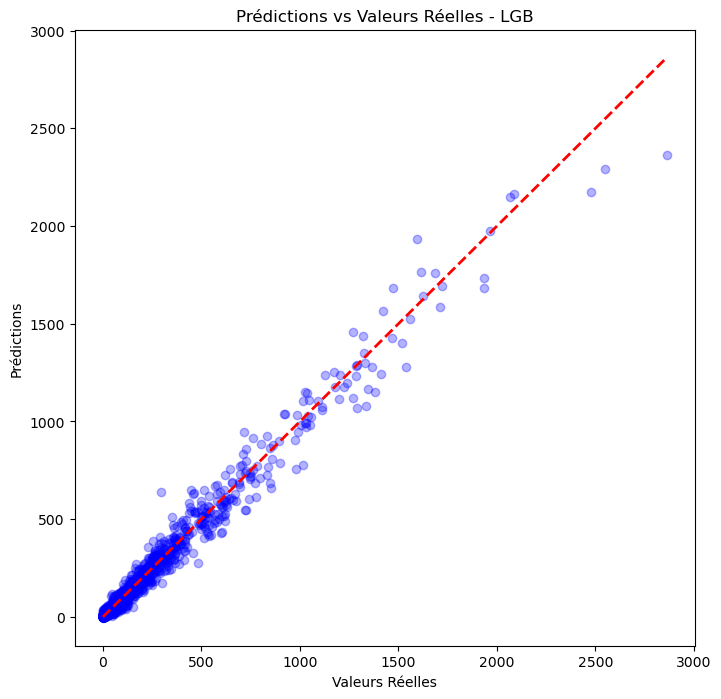

In [115]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test2, y_pred_lgb2, alpha=0.3, color="blue")
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'r--', lw=2)
plt.xlabel("Valeurs Réelles")
plt.ylabel("Prédictions")
plt.title("Prédictions vs Valeurs Réelles - LGB")
plt.show()

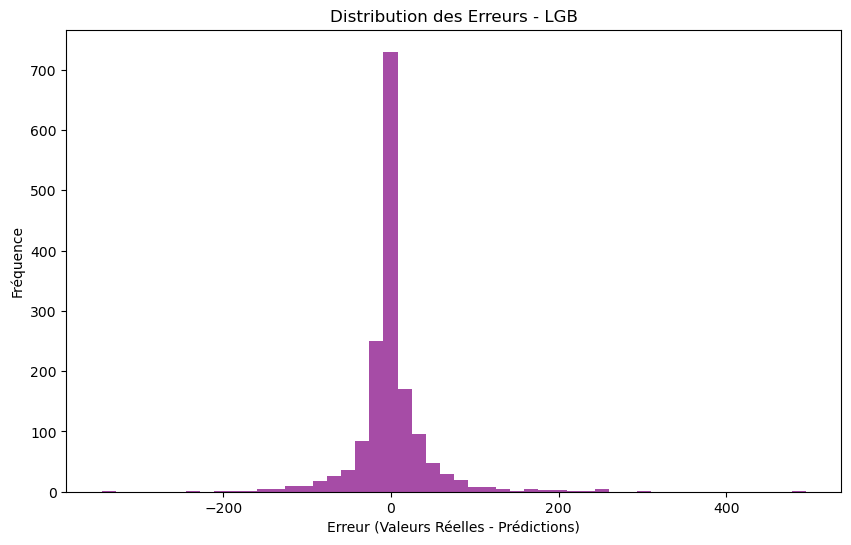

In [116]:
errors_lgb2 = y_test2 - y_pred_lgb2
plt.figure(figsize=(10, 6))
plt.hist(errors_lgb2, bins=50, color="purple", alpha=0.7)
plt.xlabel("Erreur (Valeurs Réelles - Prédictions)")
plt.ylabel("Fréquence")
plt.title("Distribution des Erreurs - LGB")
plt.show()

#### XGBoost ####

In [117]:
# XGBoost
from xgboost import XGBRegressor # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore

# Séparer les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# Initialiser le modèle XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42, verbosity=1)

# Entraîner le modèle
xgb_model.fit(X_train, y_train)

# Faire des prédictions
y_pred_xgb = xgb_model.predict(X_test)

# Évaluer les performances
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - Mean Absolute Error (MAE) : {mae_xgb}")
print(f"XGBoost - Root Mean Squared Error (RMSE) : {rmse_xgb}")
print(f"XGBoost - Coefficient de détermination (R²) : {r2_xgb}")

XGBoost - Mean Absolute Error (MAE) : 14.475145290075444
XGBoost - Root Mean Squared Error (RMSE) : 22.302226502905246
XGBoost - Coefficient de détermination (R²) : 0.9422960681944185


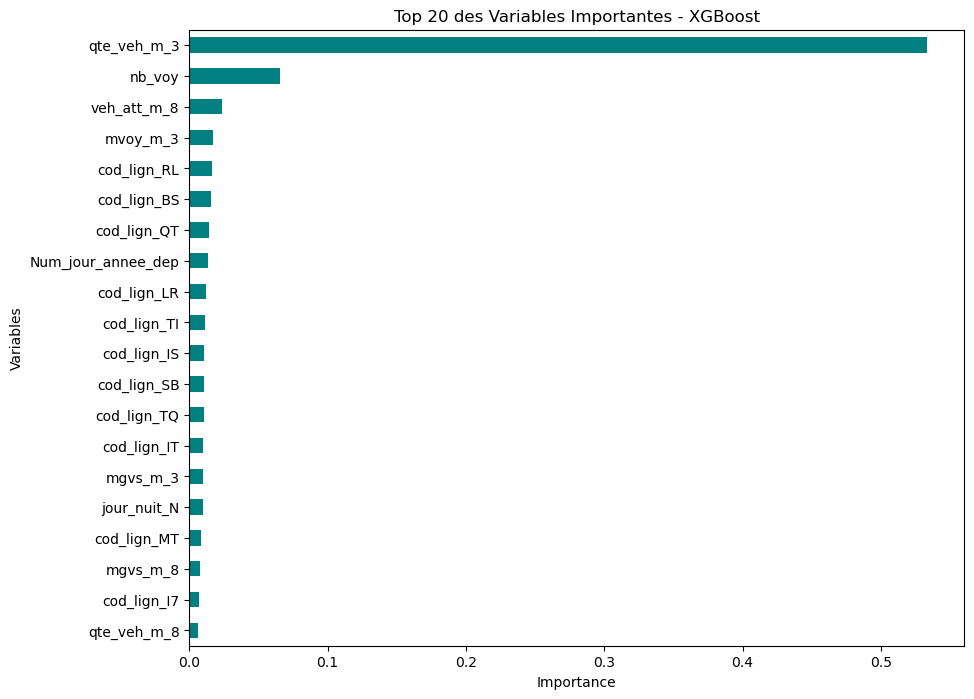

In [118]:
# Extraire et trier les importances des caractéristiques pour XGBoost
importances_xgb = xgb_model.feature_importances_  # Méthode spécifique pour XGBoost
features_xgb = X.columns
feature_importances_xgb = pd.Series(importances_xgb, index=features)
feature_importances_xgb = feature_importances_xgb.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_xgb.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - XGBoost")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

In [119]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
random_search_xgb = RandomizedSearchCV(XGBRegressor(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
random_search_xgb.fit(X, y)
print("Meilleurs paramètres pour XGBoost :", random_search_xgb.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleurs paramètres pour XGBoost : {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2}


In [120]:
from xgboost import XGBRegressor # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore

# Initialiser le modèle avec les meilleurs paramètres
xgb_model_optimized = XGBRegressor(
    subsample=0.8,
    n_estimators=200,
    max_depth=3,
    learning_rate=0.2,
    random_state=42
)

# Entraîner le modèle sur les données d'entraînement
xgb_model_optimized.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred_optimized = xgb_model_optimized.predict(X_test)

# Évaluer les performances
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
rmse_optimized = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
r2_optimized = r2_score(y_test, y_pred_optimized)

print(f"XGBoost Optimisé - Mean Absolute Error (MAE) : {mae_optimized}")
print(f"XGBoost Optimisé - Root Mean Squared Error (RMSE) : {rmse_optimized}")
print(f"XGBoost Optimisé - Coefficient de détermination (R²) : {r2_optimized}")

XGBoost Optimisé - Mean Absolute Error (MAE) : 15.15016265239895
XGBoost Optimisé - Root Mean Squared Error (RMSE) : 22.44320617252019
XGBoost Optimisé - Coefficient de détermination (R²) : 0.9415642315327041


In [121]:
# Ajouter les prédictions et les erreurs à un DataFrame pour analyse
df_results_xgb = X_test.copy()
df_results_xgb['y_test'] = y_test
df_results_xgb['y_pred'] = y_pred_optimized
df_results_xgb['err-abs'] = abs(df_results_xgb['y_test'] - df_results_xgb['y_pred'])

# Afficher le dataframe dans l'ordre décroissant par rapport à l'erreur
df_results_xgb = df_results_xgb.sort_values(by='err-abs', ascending=False)
df_results_xgb.head(20)

,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err-abs
9593,225,159.0,94.0,53.0,24.0,8.0,0.0,159.0,94.0,53.0,24.0,22.0,22.0,10.0,29.0,3.0,6.0,5.0,0.0,980.0,828.0,164.0,212.0,163.0,88.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,180.0,349.192841,169.192841
7231,194,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,186.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,221.0,78.265327,142.734673
7161,193,7.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,286.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,235.0,104.781906,130.218094
9121,219,6.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,3.0,2.0,2.0,0.0,0.0,0.0,326.0,334.0,44.0,52.0,58.0,24.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,183.0,52.857506,130.142494
9510,224,77.0,23.0,9.0,3.0,1.0,0.0,59.0,15.0,7.0,3.0,3.0,3.0,44.0,17.0,8.0,7.0,5.0,0.0,301.0,134.0,24.0,95.0,52.0,16.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,286.0,415.017120,129.017120
4537,151,14.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,49.0,60.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184.0,70.213287,113.786713
7860,202,42.0,8.0,2.0,0.0,0.0,0.0,146.0,8.0,2.0,0.0,0.0,0.0,39.0,2.0,3.0,2.0,0.0,0.0,1168.0,176.0,408.0,160.0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,332.0,218.836258,113.163742
6330,181,9.0,1.0,0.0,0.0,0.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,2.0,0.0,0.0,235.0,108.0,115.0,77.0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213.0,103.559906,109.440094
5892,174,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,11.0,7.0,0.0,0.0,0.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,155.0,45.841393,109.158607
4966,159,4.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,65.0,60.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0

In [122]:
# Export excel
df_results_xgb.to_excel("df_results_xgb.xlsx", index=False)

In [123]:
# XGBoost
from xgboost import XGBRegressor # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore

# Séparer les données
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42) 

# Initialiser le modèle XGBoost
xgb_model2 = XGBRegressor(n_estimators=100, random_state=42, verbosity=1)

# Entraîner le modèle
xgb_model2.fit(X_train2, y_train2)

# Faire des prédictions
y_pred_xgb2 = xgb_model2.predict(X_test2)

# Évaluer les performances
mae_xgb2 = mean_absolute_error(y_test2, y_pred_xgb2)
rmse_xgb2 = np.sqrt(mean_squared_error(y_test2, y_pred_xgb2))
r2_xgb2 = r2_score(y_test2, y_pred_xgb2)

print(f"XGBoost - Mean Absolute Error (MAE) : {mae_xgb2}")
print(f"XGBoost - Root Mean Squared Error (RMSE) : {rmse_xgb2}")
print(f"XGBoost - Coefficient de détermination (R²) : {r2_xgb2}")

XGBoost - Mean Absolute Error (MAE) : 24.959253112435906
XGBoost - Root Mean Squared Error (RMSE) : 48.11177761480152
XGBoost - Coefficient de détermination (R²) : 0.9758386544367406


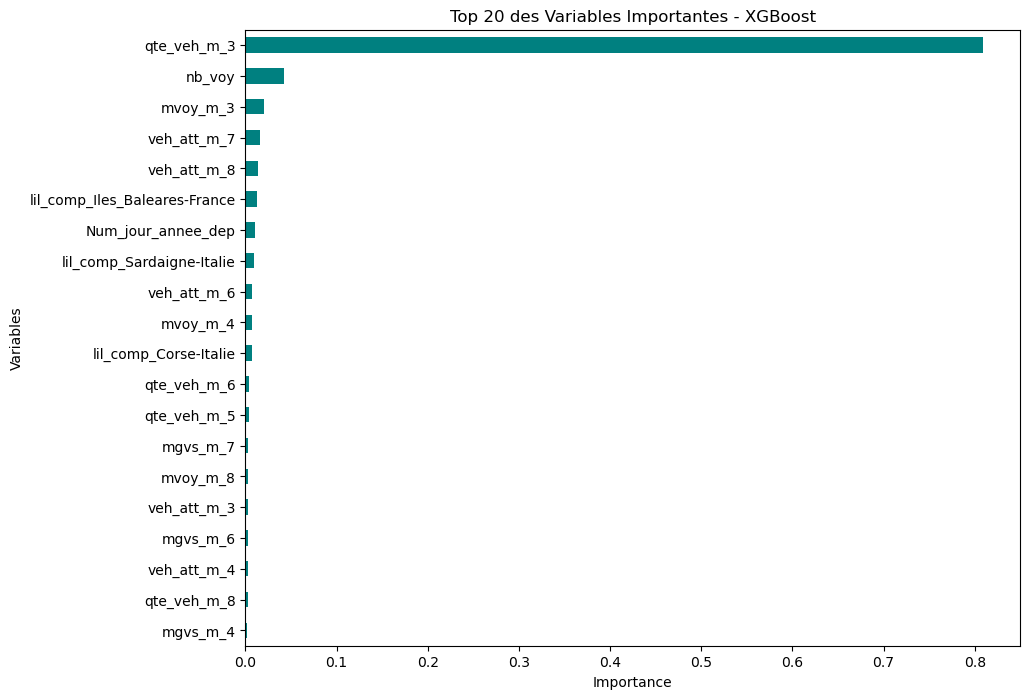

In [124]:
# Extraire et trier les importances des caractéristiques pour XGBoost
importances_xgb2 = xgb_model2.feature_importances_  # Méthode spécifique pour XGBoost
features_xgb2 = X2.columns
feature_importances_xgb2 = pd.Series(importances_xgb2, index=features_xgb2)
feature_importances_xgb2 = feature_importances_xgb2.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_xgb2.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - XGBoost")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

In [125]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
random_search_xgb2 = RandomizedSearchCV(XGBRegressor(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
random_search_xgb2.fit(X2, y2)
print("Meilleurs paramètres pour XGBoost :", random_search_xgb2.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleurs paramètres pour XGBoost : {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2}


In [126]:
from xgboost import XGBRegressor # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore

# Initialiser le modèle avec les meilleurs paramètres
xgb_model_optimized2 = XGBRegressor(
    subsample=1.0,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.2,
    random_state=42
)

# Entraîner le modèle sur les données d'entraînement
xgb_model_optimized2.fit(X_train2, y_train2)

# Faire des prédictions sur les données de test
y_pred_optimized2 = xgb_model_optimized2.predict(X_test2)

# Évaluer les performances
mae_optimized2 = mean_absolute_error(y_test2, y_pred_optimized2)
rmse_optimized2 = np.sqrt(mean_squared_error(y_test2, y_pred_optimized2))
r2_optimized2 = r2_score(y_test2, y_pred_optimized2)

print(f"XGBoost Optimisé - Mean Absolute Error (MAE) : {mae_optimized2}")
print(f"XGBoost Optimisé - Root Mean Squared Error (RMSE) : {rmse_optimized2}")
print(f"XGBoost Optimisé - Coefficient de détermination (R²) : {r2_optimized2}")

XGBoost Optimisé - Mean Absolute Error (MAE) : 26.473695346637854
XGBoost Optimisé - Root Mean Squared Error (RMSE) : 47.41856543408269
XGBoost Optimisé - Coefficient de détermination (R²) : 0.9765298896159632


In [127]:
# Ajouter les prédictions et les erreurs à un DataFrame pour analyse
df_results_xgb2 = X_test2.copy()
df_results_xgb2['y_test'] = y_test2
df_results_xgb2['y_pred'] = y_pred_optimized2
df_results_xgb2['err-abs'] = abs(df_results_xgb2['y_test'] - df_results_xgb2['y_pred'])

# Afficher le dataframe dans l'ordre décroissant par rapport à l'erreur
df_results_xgb2 = df_results_xgb2.sort_values(by='err-abs', ascending=False)
df_results_xgb2.head(20)

,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles_Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err-abs
5247,233,823.0,472.0,219.0,117.0,32.0,0.0,823.0,352.0,176.0,93.0,60.0,60.0,115.0,140.0,17.0,23.0,15.0,0.0,700.0,957.0,93.0,141.0,88.0,118.0,5,0,0,0,0,0,0,1,1595.0,1931.309448,336.309448
5338,236,653.0,284.0,96.0,53.0,11.0,1.0,665.0,284.0,96.0,53.0,27.0,27.0,79.0,76.0,37.0,27.0,11.0,0.0,470.0,417.0,183.0,199.0,71.0,118.0,7,0,0,0,0,0,0,1,1934.0,1601.048218,332.951782
5412,238,262.0,134.0,46.0,22.0,5.0,0.0,262.0,134.0,46.0,22.0,5.0,0.0,72.0,63.0,27.0,5.0,26.0,0.0,381.0,401.0,217.0,101.0,112.0,0.0,7,0,0,0,0,0,0,0,715.0,1033.180420,318.180420
5055,227,627.0,255.0,109.0,46.0,22.0,0.0,608.0,206.0,76.0,33.0,28.0,28.0,131.0,76.0,12.0,19.0,25.0,0.0,416.0,414.0,70.0,83.0,136.0,28.0,7,0,0,0,0,0,0,1,1932.0,1622.417114,309.582886
4523,210,175.0,83.0,47.0,20.0,0.0,0.0,175.0,83.0,47.0,28.0,28.0,28.0,50.0,8.0,4.0,4.0,0.0,0.0,762.0,191.0,87.0,93.0,132.0,55.0,5,1,0,0,0,0,0,1,620.0,904.815491,284.815491
2852,155,165.0,110.0,60.0,15.0,0.0,0.0,95.0,79.0,78.0,79.0,79.0,79.0,1.0,10.0,0.0,0.0,0.0,0.0,11.0,33.0,25.0,29.0,8.0,4.0,2,0,0,0,0,0,1,0,294.0,571.937256,277.937256
4863,221,383.0,138.0,68.0,26.0,9.0,0.0,200.0,64.0,27.0,13.0,13.0,13.0,36.0,43.0,14.0,10.0,4.0,0.0,458.0,486.0,104.0,96.0,65.0,43.0,5,0,0,0,0,0,0,0,1291.0,1029.124512,261.875488
3492,177,122.0,82.0,33.0,9.0,3.0,0.0,121.0,81.0,56.0,56.0,58.0,58.0,19.0,26.0,3.0,2.0,5.0,0.0,58.0,74.0,15.0,10.0,23.0,12.0,5,0,0,0,0,0,0,1,853.0,604.582214,248.417786
3460,176,228.0,138.0,60.0,22.0,5.0,0.0,224.0,136.0,102.0,102.0,102.0,104.0,41.0,52.0,20.0,21.0,32.0,0.0,178.0,152.0,72.0,87.0,92.0,37.0,6,0,0,0,0,0,0,0,1333.0,1086.939331,246.060669
4594,212,233.0,105.0,74.0,25.0,3.0,0.0,233.0,105.0,74.0,25.0,3.0,0.0,48.0,78.0,11.0,21.0,12.0,0.0,328.0,378.0,53.0,116.0,87.0,0.0,7,0,0,0,0,0,0,1,727.0,963.875671,236.875671


In [128]:
# Export excel
df_results_xgb2.to_excel("df_results_xgb2.xlsx", index=False)

### Test réseau de neurones ###

Epoch 1/200


c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8398.7021 - mae: 58.6268 - val_loss: 1275.5917 - val_mae: 23.6871
Epoch 2/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1576.8937 - mae: 26.5143 - val_loss: 1031.6625 - val_mae: 21.7696
Epoch 3/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1301.6099 - mae: 24.6779 - val_loss: 880.9521 - val_mae: 20.4082
Epoch 4/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1165.8727 - mae: 23.5740 - val_loss: 794.2812 - val_mae: 19.6795
Epoch 5/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1078.5110 - mae: 22.6907 - val_loss: 1033.5474 - val_mae: 21.0788
Epoch 6/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1128.6177 - mae: 22.5616 - val_loss: 725.1163 - val_mae: 17.9828
Epoch 7/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1005.2855 - mae: 21.3915 - val_loss: 723.8299 - val_mae: 17.9408
Epoch 8/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 940.6934 - mae: 20.5897 - val_loss: 625.7214 - val_mae: 16.8930
Ep

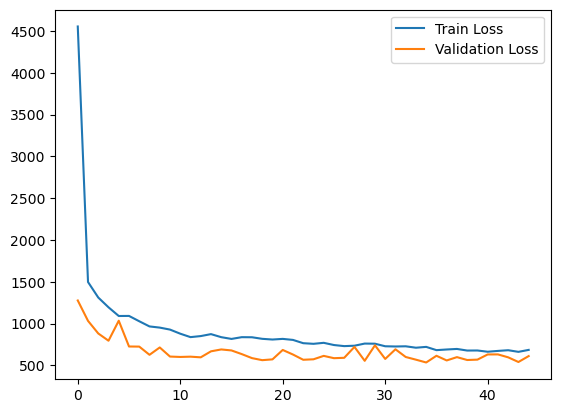

In [129]:
import tensorflow as tf # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Dropout # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Division des données
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Construction du modèle
neural_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),  
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  
])

# Compilation
optimizer = Adam(learning_rate=0.001)
neural_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
#model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Ajouter un eraly stop pour éviter le sur-apprentissage
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Entraînement
history = neural_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

# Évaluation
y_pred_neural = neural_model.predict(X_test).flatten()
mae_neural = mean_absolute_error(y_test, y_pred_neural)
rmse_neural = np.sqrt(mean_squared_error(y_test, y_pred_neural))
r2_neural = r2_score(y_test, y_pred_neural)

print(f"Neural Network - Mean Absolute Error (MAE) : {mae_neural}")
print(f"Neural Network - Root Mean Squared Error (RMSE) : {rmse_neural}")
print(f"Neural Network - Coefficient de détermination (R²) : {r2_neural}")

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [130]:
# Création dataframe avec les résultats
df_results_neural = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred_neural,
    'err-abs': abs(y_test - y_pred_neural)
})

# Trié Dataframe par erreur absolue
df_results_neural = df_results_neural.sort_values(by='err-abs', ascending=False)
df_results_neural.head(20)

,y_test,y_pred,err-abs
9079,363.0,0.512233,362.487767
2963,143.0,304.232452,161.232452
9670,623.0,469.668091,153.331909
7231,221.0,77.333679,143.666321
8313,427.0,290.612793,136.387207
7860,332.0,198.325684,133.674316
7161,235.0,107.778046,127.221954
9593,180.0,303.803894,123.803894
3620,342.0,218.392258,123.607742
6330,213.0,92.872108,120.127892


In [131]:
# Exportation des résultats dans un fichier Excel
df_results_neural.to_excel("df_results_neural.xlsx", index=False)

Epoch 1/200


c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 76572.0703 - mae: 130.6137 - val_loss: 12270.0254 - val_mae: 61.8229
Epoch 2/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12203.8643 - mae: 59.0205 - val_loss: 8048.2090 - val_mae: 44.8140
Epoch 3/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7103.0420 - mae: 46.3540 - val_loss: 6771.6182 - val_mae: 42.3132
Epoch 4/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7954.3564 - mae: 46.4331 - val_loss: 5349.4805 - val_mae: 36.3919
Epoch 5/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6083.4023 - mae: 41.2215 - val_loss: 5370.9990 - val_mae: 35.8605
Epoch 6/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5479.7134 - mae: 39.1755 - val_loss: 5346.3042 - val_mae: 33.5258
Epoch 7/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5685.8086 - mae: 39.6655 - val_loss: 4306.7197 - val_mae: 32.9822
Epoch 8/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5294.8276 - mae: 39.0477 - val_loss: 5361.2202 - val_mae: 

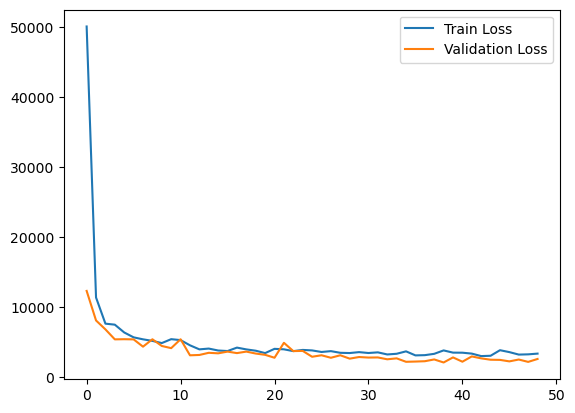

In [132]:
import tensorflow as tf # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Dropout # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

# Normalisation des données
scaler2 = StandardScaler()
X_scaled2 = scaler2.fit_transform(X2)

# Division des données
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled2, y2, test_size=0.2, random_state=42)

# Construction du modèle
neural_model2 = Sequential([
    Dense(128, activation='relu', input_dim=X_train2.shape[1]),
    Dropout(0.2),  
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  
])

# Compilation
optimizer = Adam(learning_rate=0.001)
neural_model2.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
#model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Ajouter un eraly stop pour éviter le sur-apprentissage
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Entraînement
history2 = neural_model2.fit(
    X_train2, y_train2,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

# Évaluation
y_pred_neural2 = neural_model2.predict(X_test2).flatten()
mae_neural2 = mean_absolute_error(y_test2, y_pred_neural2)
rmse_neural2 = np.sqrt(mean_squared_error(y_test2, y_pred_neural2))
r2_neural2 = r2_score(y_test2, y_pred_neural2)

print(f"Neural Network - Mean Absolute Error (MAE) : {mae_neural2}")
print(f"Neural Network - Root Mean Squared Error (RMSE) : {rmse_neural2}")
print(f"Neural Network - Coefficient de détermination (R²) : {r2_neural2}")

plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [133]:
# Création dataframe avec les résultats
df_results_neural2 = pd.DataFrame({
    'y_test': y_test2,
    'y_pred': y_pred_neural2,
    'err-abs': abs(y_test2 - y_pred_neural2)
})

# Trié Dataframe par erreur absolue
df_results_neural2 = df_results_neural2.sort_values(by='err-abs', ascending=False)
df_results_neural2.head(20)

,y_test,y_pred,err-abs
6044,1613.0,1263.704590,349.295410
5394,2547.0,2198.753174,348.246826
4995,2861.0,3139.787109,278.787109
4677,1381.0,1123.035156,257.964844
4863,1291.0,1033.568115,257.431885
4584,776.0,519.444031,256.555969
4487,1413.0,1157.074707,255.925293
4093,1345.0,1092.759888,252.240112
5338,1934.0,1683.932373,250.067627
3659,795.0,556.447937,238.552063


In [134]:
# Exportation des résultats dans un fichier Excel
df_results_neural2.to_excel("df_results_neural2.xlsx", index=False)

### CatBoost ###

Learning rate set to 0.39428
0:	learn: 65.1071949	total: 146ms	remaining: 14.4s
1:	learn: 48.5633091	total: 151ms	remaining: 7.4s
2:	learn: 39.5847589	total: 155ms	remaining: 5.01s
3:	learn: 34.3465828	total: 159ms	remaining: 3.82s
4:	learn: 31.2793415	total: 162ms	remaining: 3.09s
5:	learn: 29.9767145	total: 166ms	remaining: 2.6s
6:	learn: 28.8616174	total: 171ms	remaining: 2.27s
7:	learn: 28.2146550	total: 174ms	remaining: 2.01s
8:	learn: 27.5787023	total: 178ms	remaining: 1.8s
9:	learn: 27.1927690	total: 181ms	remaining: 1.63s
10:	learn: 26.6958680	total: 185ms	remaining: 1.5s
11:	learn: 26.3918106	total: 190ms	remaining: 1.39s
12:	learn: 26.2095304	total: 193ms	remaining: 1.29s
13:	learn: 25.9566317	total: 197ms	remaining: 1.21s
14:	learn: 25.6572430	total: 201ms	remaining: 1.14s
15:	learn: 25.3778812	total: 205ms	remaining: 1.07s
16:	learn: 25.1841924	total: 209ms	remaining: 1.02s
17:	learn: 25.0256343	total: 213ms	remaining: 973ms
18:	learn: 24.8816057	total: 218ms	remaining: 928

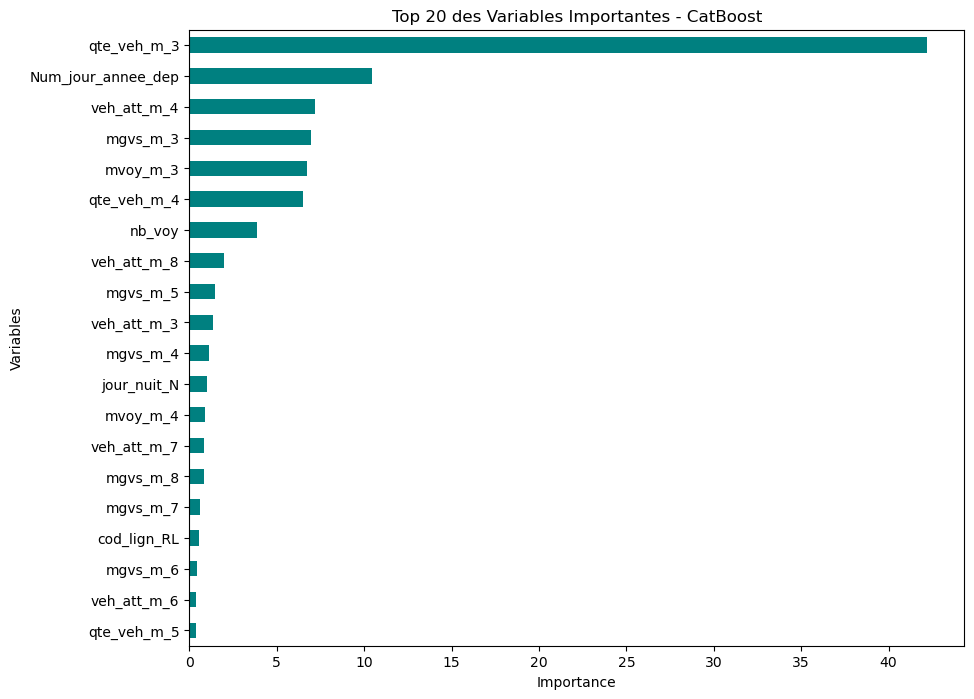

In [135]:
# CatBoost
from catboost import CatBoostRegressor # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Séparer les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser le modèle CatBoost
cat_model_all = CatBoostRegressor(n_estimators=100, random_state=42, verbose=1)

# Entraîner le modèle
cat_model_all.fit(X_train, y_train)

# Faire des prédictions
y_all_pred_cat = cat_model_all.predict(X_test)

# Évaluer les performances
mae_all_cat = mean_absolute_error(y_test, y_all_pred_cat)
rmse_all_cat = np.sqrt(mean_squared_error(y_test, y_all_pred_cat))
r2_all_cat = r2_score(y_test, y_all_pred_cat)

print(f"CatBoost - Mean Absolute Error (MAE) : {mae_all_cat}")
print(f"CatBoost - Root Mean Squared Error (RMSE) : {rmse_all_cat}")
print(f"CatBoost - Coefficient de détermination (R²) : {r2_all_cat}")

# Extraire et trier les importances des caractéristiques pour CatBoost
importances_cat = cat_model_all.feature_importances_
features_cat = X.columns
feature_importances_cat = pd.Series(importances_cat, index=features_cat)
feature_importances_cat = feature_importances_cat.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_cat.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - CatBoost")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

Learning rate set to 0.35635
0:	learn: 204.1787011	total: 3.81ms	remaining: 378ms
1:	learn: 150.4727973	total: 7.63ms	remaining: 374ms
2:	learn: 116.4894974	total: 10.5ms	remaining: 338ms
3:	learn: 95.2429290	total: 13.3ms	remaining: 319ms
4:	learn: 80.6764594	total: 16ms	remaining: 304ms
5:	learn: 71.6828182	total: 18.4ms	remaining: 288ms
6:	learn: 64.8227986	total: 21.2ms	remaining: 282ms
7:	learn: 60.0833115	total: 26.5ms	remaining: 305ms
8:	learn: 57.3616041	total: 28.9ms	remaining: 293ms
9:	learn: 55.3743449	total: 31.6ms	remaining: 284ms
10:	learn: 53.6083129	total: 34.1ms	remaining: 276ms
11:	learn: 51.9321537	total: 37.3ms	remaining: 274ms
12:	learn: 50.5723594	total: 41.4ms	remaining: 277ms
13:	learn: 49.4797942	total: 47ms	remaining: 289ms
14:	learn: 48.1832369	total: 49.7ms	remaining: 282ms
15:	learn: 47.4335226	total: 52.6ms	remaining: 276ms
16:	learn: 46.8582458	total: 56.3ms	remaining: 275ms
17:	learn: 46.2745755	total: 59ms	remaining: 269ms
18:	learn: 45.6875812	total: 6

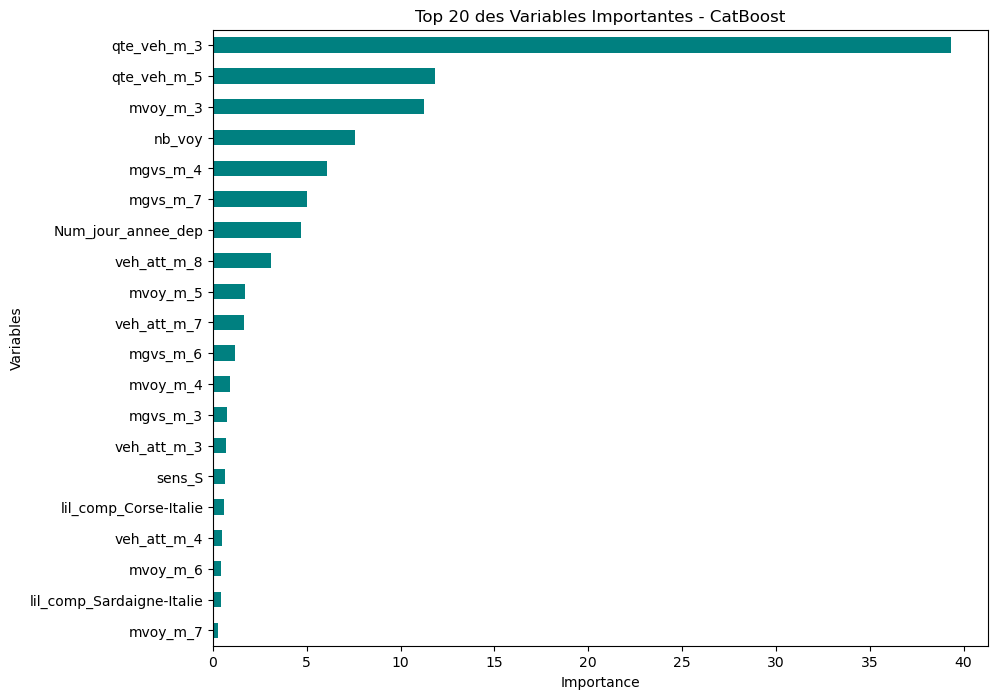

In [136]:
# CatBoost
from catboost import CatBoostRegressor # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Séparer les données
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Initialiser le modèle CatBoost
cat_model_all2 = CatBoostRegressor(n_estimators=100, random_state=42, verbose=1)

# Entraîner le modèle
cat_model_all2.fit(X_train2, y_train2)

# Faire des prédictions
y_all_pred_cat2 = cat_model_all2.predict(X_test2)

# Évaluer les performances
mae_all_cat2 = mean_absolute_error(y_test2, y_all_pred_cat2)
rmse_all_cat2 = np.sqrt(mean_squared_error(y_test2, y_all_pred_cat2))
r2_all_cat2 = r2_score(y_test2, y_all_pred_cat2)

print(f"CatBoost - Mean Absolute Error (MAE) : {mae_all_cat2}")
print(f"CatBoost - Root Mean Squared Error (RMSE) : {rmse_all_cat2}")
print(f"CatBoost - Coefficient de détermination (R²) : {r2_all_cat2}")

# Extraire et trier les importances des caractéristiques pour CatBoost
importances_cat2 = cat_model_all2.feature_importances_
features_cat2 = X2.columns
feature_importances_cat2 = pd.Series(importances_cat2, index=features_cat2)
feature_importances_cat2 = feature_importances_cat2.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_cat2.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - CatBoost")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

### LSTM ###

Epoch 1/200


c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 11126.7041 - mae: 69.3667 - val_loss: 1944.2321 - val_mae: 32.2244
Epoch 2/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1884.4473 - mae: 31.6174 - val_loss: 1128.7410 - val_mae: 24.9601
Epoch 3/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1387.1112 - mae: 26.6673 - val_loss: 952.9323 - val_mae: 22.5870
Epoch 4/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1151.2327 - mae: 24.1363 - val_loss: 858.9062 - val_mae: 21.5977
Epoch 5/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1092.1047 - mae: 23.3636 - val_loss: 797.6648 - val_mae: 20.3844
Epoch 6/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1021.9794 - mae: 22.6980 - val_loss: 739.2136 - val_mae: 19.6360
Epoch 7/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 941.5888 - mae: 21.2346 - val_loss: 712.6944 - val_mae: 18.9667
Epoch 8/200
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 920.3615 - mae: 21.2897 - val_loss: 673.4942 - val_mae: 18.1969
Epo

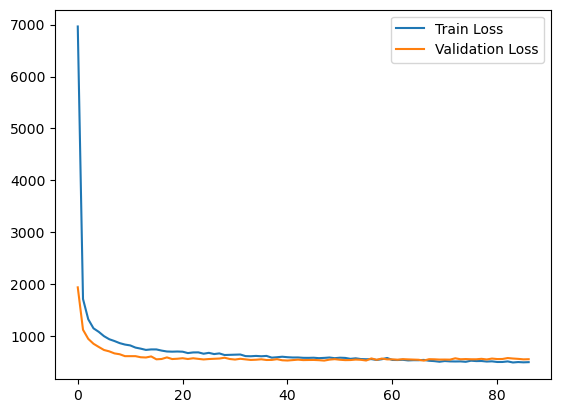

,Modèle,MAE,RMSE,R²
0,Random Forest,16.129569,25.079692,0.927028
1,LightGBM,14.471939,22.012358,0.943786
2,XGBoost,14.475145,22.302227,0.942296
3,Neural Network,16.229258,25.578406,0.924098
4,CatBoost,14.984210,22.471918,0.941415
5,LSTM,15.024967,24.348834,0.931220


In [137]:
# LSTM
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

# Normalisation des données
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X)

# Division des données
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all_scaled, y, test_size=0.2, random_state=42)

# Remodelage des données pour LSTM
X_all_train = X_all_train.reshape((X_all_train.shape[0], 1, X_all_train.shape[1]))
X_all_test = X_all_test.reshape((X_all_test.shape[0], 1, X_all_test.shape[1]))

# Construction du modèle LSTM
lstm_model_all = Sequential([
    LSTM(128, activation='relu', input_shape=(X_all_train.shape[1], X_all_train.shape[2])),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

# Compilation
optimizer = Adam(learning_rate=0.001)
lstm_model_all.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Early Stopping
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True
)

# Entraînement
history = lstm_model_all.fit(
    X_all_train, y_all_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

# Évaluation
y_all_pred_lstm = lstm_model_all.predict(X_all_test).flatten()
mae_all_lstm = mean_absolute_error(y_all_test, y_all_pred_lstm)
rmse_all_lstm = np.sqrt(mean_squared_error(y_all_test, y_all_pred_lstm))
r2_all_lstm = r2_score(y_all_test, y_all_pred_lstm)

print(f"LSTM - Mean Absolute Error (MAE) : {mae_all_lstm}")
print(f"LSTM - Root Mean Squared Error (RMSE) : {rmse_all_lstm}")
print(f"LSTM - Coefficient de détermination (R²) : {r2_all_lstm}")

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Comparaison des modèles
# Comparaison des performances
models = ['Random Forest', 'LightGBM', 'XGBoost', 'Neural Network', 'CatBoost', 'LSTM']
mae_scores = [mae_opti, mae_lgb, mae_xgb, mae_neural, mae_all_cat, mae_all_lstm]
rmse_scores = [rmse_opti, rmse_lgb, rmse_xgb, rmse_neural, rmse_all_cat, rmse_all_lstm]
r2_scores = [r2_opti, r2_lgb, r2_xgb, r2_neural, r2_all_cat, r2_all_lstm]

# Créer un DataFrame pour afficher les scores
df_scores = pd.DataFrame({
    'Modèle': models,
    'MAE': mae_scores,
    'RMSE': rmse_scores,
    'R²': r2_scores
})

# Afficher les scores
df_scores

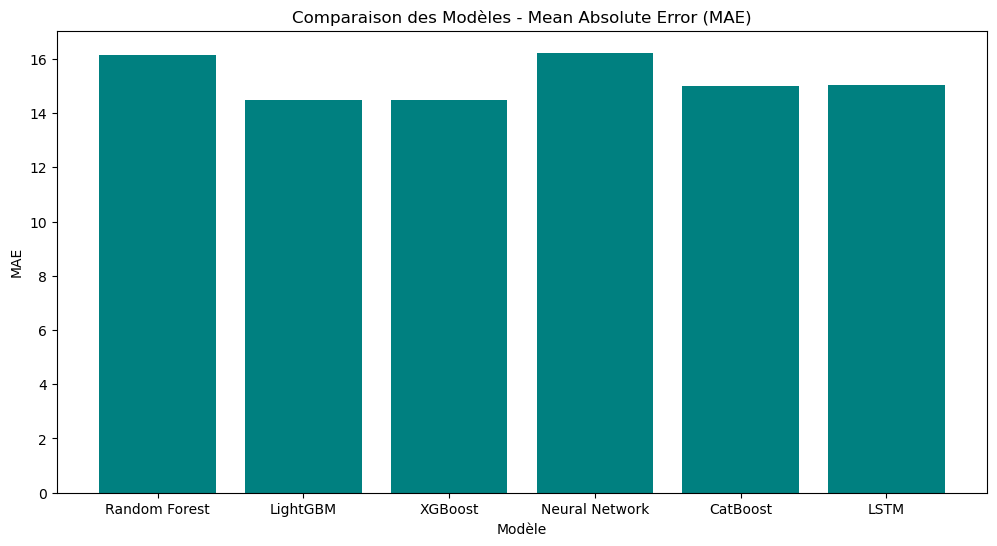

In [138]:
# Comparaison des scores MAE
plt.figure(figsize=(12, 6))
plt.bar(models, mae_scores, color='teal')
plt.xlabel('Modèle')
plt.ylabel('MAE')
plt.title('Comparaison des Modèles - Mean Absolute Error (MAE)')
plt.show()

Epoch 1/200


c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 87162.7422 - mae: 147.7178 - val_loss: 23969.9551 - val_mae: 83.0120
Epoch 2/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22361.7949 - mae: 83.6246 - val_loss: 16853.3164 - val_mae: 68.5255
Epoch 3/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15320.2510 - mae: 69.1100 - val_loss: 10209.4434 - val_mae: 54.9197
Epoch 4/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8084.8784 - mae: 52.6919 - val_loss: 6135.6753 - val_mae: 45.4609
Epoch 5/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6939.4453 - mae: 48.1591 - val_loss: 4864.2183 - val_mae: 41.2352
Epoch 6/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5429.2656 - mae: 42.4174 - val_loss: 5697.2920 - val_mae: 39.7536
Epoch 7/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5304.3760 - mae: 41.7827 - val_loss: 4987.9209 - val_mae: 38.3814
Epoch 8/200
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4808.7998 - mae: 39.6028 - val_loss: 3913.0322 - val_ma

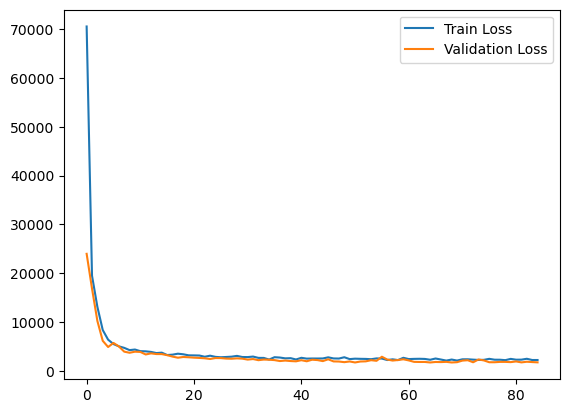

,Modèle,MAE,RMSE,R²
0,Random Forest,28.481028,56.946084,0.966151
1,LightGBM,24.004264,46.007619,0.977906
2,XGBoost,24.959253,48.111778,0.975839
3,Neural Network,27.655413,51.172943,0.972666
4,CatBoost,24.820689,47.019051,0.976924
5,LSTM,24.314323,41.913235,0.981663


In [140]:
# LSTM
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

# Normalisation des données
scaler = StandardScaler()
X_all_scaled2 = scaler.fit_transform(X2)

# Division des données
X_all_train2, X_all_test2, y_all_train2, y_all_test2 = train_test_split(X_all_scaled2, y2, test_size=0.2, random_state=42)

# Remodelage des données pour LSTM
X_all_train2 = X_all_train2.reshape((X_all_train2.shape[0], 1, X_all_train2.shape[1]))
X_all_test2 = X_all_test2.reshape((X_all_test2.shape[0], 1, X_all_test2.shape[1]))

# Construction du modèle LSTM
lstm_model_all2 = Sequential([
    LSTM(128, activation='relu', input_shape=(X_all_train2.shape[1], X_all_train2.shape[2])),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

# Compilation
optimizer = Adam(learning_rate=0.001)
lstm_model_all2.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Early Stopping
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True
)

# Entraînement
history2 = lstm_model_all2.fit(
    X_all_train2, y_all_train2,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

# Évaluation
y_all_pred_lstm2 = lstm_model_all2.predict(X_all_test2).flatten()
mae_all_lstm2 = mean_absolute_error(y_all_test2, y_all_pred_lstm2)
rmse_all_lstm2 = np.sqrt(mean_squared_error(y_all_test2, y_all_pred_lstm2))
r2_all_lstm2 = r2_score(y_all_test2, y_all_pred_lstm2)

print(f"LSTM - Mean Absolute Error (MAE) : {mae_all_lstm2}")
print(f"LSTM - Root Mean Squared Error (RMSE) : {rmse_all_lstm2}")
print(f"LSTM - Coefficient de détermination (R²) : {r2_all_lstm2}")

plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Comparaison des modèles
# Comparaison des performances
models2 = ['Random Forest', 'LightGBM', 'XGBoost', 'Neural Network', 'CatBoost', 'LSTM']
mae_scores2 = [mae_opti2, mae_lgb2, mae_xgb2, mae_neural2, mae_all_cat2, mae_all_lstm2]
rmse_scores2 = [rmse_opti2, rmse_lgb2, rmse_xgb2, rmse_neural2, rmse_all_cat2, rmse_all_lstm2]
r2_scores2 = [r2_opti2, r2_lgb2, r2_xgb2, r2_neural2, r2_all_cat2, r2_all_lstm2]

# Créer un DataFrame pour afficher les scores
df_scores2 = pd.DataFrame({
    'Modèle': models2,
    'MAE': mae_scores2,
    'RMSE': rmse_scores2,
    'R²': r2_scores2
})

# Afficher les scores
df_scores2

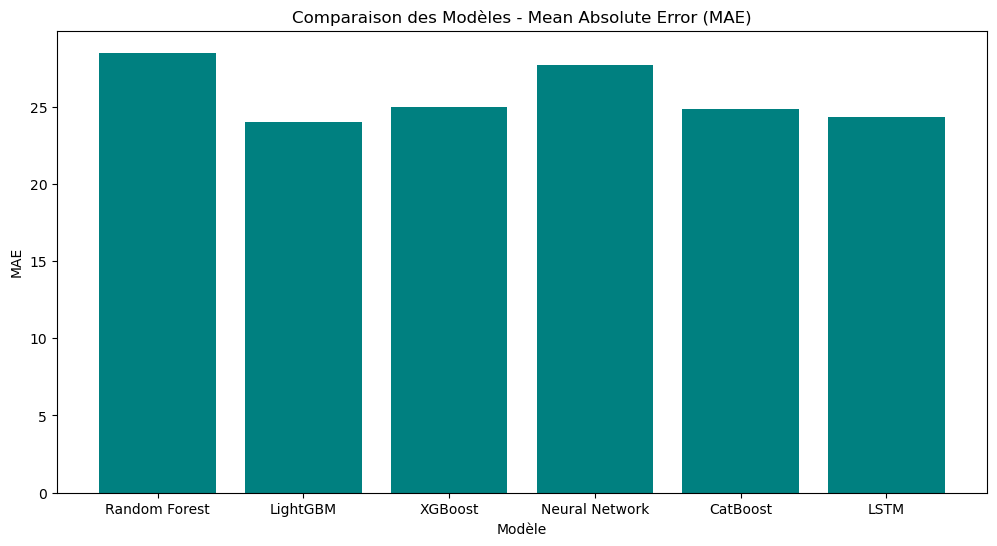

In [141]:
# Comparaison des scores MAE
plt.figure(figsize=(12, 6))
plt.bar(models2, mae_scores2, color='teal')
plt.xlabel('Modèle')
plt.ylabel('MAE')
plt.title('Comparaison des Modèles - Mean Absolute Error (MAE)')
plt.show()

In [ ]:
# # Grid Search ou RandomizedSearch
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.ensemble import RandomForestRegressor
# from scipy.stats import randint

# # Définir la grille de paramètres pour RandomizedSearchCV
# param_distributions = {
#     'n_estimators': randint(10, 100),  # Limiter le nombre d'arbres
#     'max_depth': [None, 10, 20, 30],  # Limiter la profondeur
#     'max_features': ['auto', 'sqrt', 'log2'],  # Contrôler le nombre de variables
# }

# # Initialiser RandomForest avec RandomizedSearch
# rf_model = RandomForestRegressor(random_state=42)
# random_search = RandomizedSearchCV(rf_model, param_distributions, n_iter=20, cv=3, n_jobs=-1, verbose=1)
# random_search.fit(X, y)

# # Afficher les meilleurs paramètres trouvés
# print("Meilleurs paramètres trouvés :", random_search.best_params_)

In [ ]:
# # Enregistrer un modèle
# import joblib

# # Sauvegarder un modèle
# joblib.dump(rf_model, 'random_forest_model.joblib')

# # Charger un modèle
# rf_model = joblib.load('random_forest_model.joblib')

In [ ]:
# # Prendre un échantillon de 10 % des données
# X_sample = X.sample(frac=0.1, random_state=42)
# y_sample = y.loc[X_sample.index]

# model.fit(X_sample, y_sample)

In [ ]:
# # Arrondir pour simplifier les prédictions
# # Exemple d'arrondi pour des colonnes spécifiques
# X['colonne_numerique'] = X['colonne_numerique'].round(2)

In [ ]:
# # Méthode warm_start pour ajouter des arbres à un modèle existant
# rf_model = RandomForestRegressor(n_estimators=50, warm_start=True, random_state=42, verbose=1)

# # Premier entraînement
# rf_model.fit(X_train, y_train)

# # Augmenter le nombre d'arbres sans recommencer depuis zéro
# rf_model.n_estimators += 50
# rf_model.fit(X_train, y_train)

In [ ]:
# # Arbre unique
# from sklearn.tree import DecisionTreeRegressor

# dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)
# dt_model.fit(X_train, y_train)

# # Calculer le score sur un ensemble de test
# score = dt_model.score(X_test, y_test)
# print("Score de l'arbre de décision :", score)

In [ ]:
# Avec tout combiné: 
# # from sklearn.ensemble import RandomForestRegressor
# import joblib

# # Paramètres optimisés
# rf_model = RandomForestRegressor(
#     n_estimators=50,          # Moins d'arbres
#     max_depth=10,             # Profondeur limitée
#     n_jobs=-1,                # Utilisation de tous les cœurs
#     warm_start=True,          # Entraînement par étapes
#     random_state=42,
#     verbose=1                 # Suivi de progression
# )

# # Entraînement par étapes et sauvegarde régulière
# for step in range(5):  # 5 étapes pour 50 arbres au total
#     rf_model.n_estimators += 10  # Ajouter 10 arbres par étape
#     rf_model.fit(X_train, y_train)
    
#     # Sauvegarder un snapshot du modèle après chaque étape
#     joblib.dump(rf_model, f'random_forest_step_{step}.joblib')
#     print(f"Modèle sauvegardé à l'étape {step}")